<a href="https://colab.research.google.com/github/isikaykarakus/BloodMNIST_C4/blob/main/Isikay_Karakus_C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blood Cell Type Classification using Deep Neural Networks

Işıkay Karakuş 2071938


This project addresses the task of **automated blood cell classification** using the **BloodMNIST** dataset, as part of the "Machine Learning for Human Data" final exam.

The objective is to develop and evaluate multiple **custom neural network architectures** to classify microscopic images of blood cells into 8 categories without relying on pretrained models.

Key aspects of this work include:
- Loading and preprocessing the BloodMNIST dataset at different resolutions (64x64 and 128x128)
- Designing and training a variety of **convolutional neural networks (CNNs)** from scratch
- Incorporating techniques such as **data augmentation**, **class weighting**, and **learning rate scheduling**
- Comparing the performance of baseline CNNs, U-Net-inspired, Inception-based and skip connection-enhanced models
- Evaluating models using accuracy, confusion matrices, class-wise performance, and loss/accuracy curves

This notebook demonstrates a systematic deep learning approach to medical image classification, emphasising different models' interpretability and performance.


As a starting point, a baseline Convolutional Neural Network (CNN) was implemented and evaluated on the BloodMNIST dataset using images sizes fo 64×64 dataset.

## Download BloodMNIST 64x64 Dataset

In [83]:
!wget https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1 -O bloodmnist_64.npz

--2025-06-03 20:07:52--  https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156251765 (149M) [application/octet-stream]
Saving to: ‘bloodmnist_64.npz’

bloodmnist_64.npz   100%[===================>] 149.01M  15.2MB/s    in 12s     

2025-06-03 20:08:05 (12.4 MB/s) - ‘bloodmnist_64.npz’ saved [156251765/156251765]



## Helper Functions

This section contains a set of utility functions used throughout the training, evaluation, and visualization of the models.

As a starting point, the dataset's class names and corresponding labels are predefined and fixed.









In [84]:
import numpy as np

# Load the dataset
data = np.load('bloodmnist_64.npz')

# Load labels correctly using the actual keys
y_train = data['train_labels']
y_val = data['val_labels']
y_test = data['test_labels']

# Combine all labels
all_labels = np.concatenate([y_train, y_val, y_test]).flatten()

# Show class names present
unique_classes = np.unique(all_labels)
print("Class Names in Dataset:")
for cls in unique_classes:
    print(f"Class {int(cls)}: {label_map[int(cls)]}")

Class Names in Dataset:
Class 0: Basophil
Class 1: Eosinophil
Class 2: Erythroblast
Class 3: Immature granulocytes
Class 4: Lymphocyte
Class 5: Monocyte
Class 6: Neutrophil
Class 7: Platelet


The utility function **plot_training_diagnostics** visualizes the training performance of a model across epochs. It plots training/validation accuracy and loss curves, and optionally includes time per epoch if provided. This helps diagnose underfitting, overfitting or performance stability across training.



In [85]:
import matplotlib.pyplot as plt

def plot_training_diagnostics(history, times_per_epoch=None, model_name="Model"):
   """
    Plots training diagnostics for a given model's history.

    Displays subplots for:
    - Training and validation accuracy over epochs.
    - Training and validation loss over epochs.

    Parameters:
    - history: Keras History object returned from model.fit().
    - times_per_epoch (list or None): Optional list of timing values per epoch.
    - model_name (str): Title to display for each plot (default is "Model").
    """


   epochs = range(1, len(history.history['accuracy']) + 1)

   fig, axs = plt.subplots(1, 3 if times_per_epoch is not None else 2, figsize=(18, 5))

   # Accuracy Plot
   axs[0].plot(epochs, history.history['accuracy'], label='Train Accuracy')
   axs[0].plot(epochs, history.history['val_accuracy'], label='Val Accuracy')
   axs[0].set_title(f'{model_name} Accuracy per Epoch')
   axs[0].set_xlabel('Epoch')
   axs[0].set_ylabel('Accuracy')
   axs[0].legend()
   axs[0].grid(True)

   # Loss Plot
   axs[1].plot(epochs, history.history['loss'], label='Train Loss')
   axs[1].plot(epochs, history.history['val_loss'], label='Val Loss')
   axs[1].set_title(f'{model_name} Loss per Epoch')
   axs[1].set_xlabel('Epoch')
   axs[1].set_ylabel('Loss')
   axs[1].legend()
   axs[1].grid(True)

   # Time per Epoch
   if times_per_epoch is not None:
       axs[2].plot(epochs, times_per_epoch, marker='o')
       axs[2].set_title(f'{model_name} Time per Epoch')
       axs[2].set_xlabel('Epoch')
       axs[2].set_ylabel('Time (seconds)')
       axs[2].grid(True)

   plt.tight_layout()
   plt.show()

## Class accuracy function

This function computes and prints the per-class accuracy of a trained classification model. It predicts labels on the test set using the model, then compares predictions with ground truth to count correct classifications per class. The function outputs accuracy for each class label defined in label_map. This is useful for evaluating how well the model performs on individual categories, especially in imbalanced datasets like BloodMNIST.



In [86]:
label_map = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}


In [87]:
def class_accuracy(model, x_test, y_test, label_map):

    """Computes and prints per-class accuracy for a given classification model.

      Parameters:
          model (tf.keras.Model): Trained Keras model to evaluate.
          x_test (np.ndarray): Test images.
          y_test (np.ndarray): True labels corresponding to x_test.
          label_map (dict): Dictionary mapping class indices to human-readable labels.

      Returns:
          None. Prints accuracy for each class."""

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = y_test

    total = [0] * len(label_map)
    correct = [0] * len(label_map)

    for true, pred in zip(y_true, y_pred):
        total[true] += 1
        if true == pred:
            correct[true] += 1

    for i in range(len(label_map)):
        acc = 100 * correct[i] / total[i] if total[i] > 0 else 0
        print(f'Accuracy of {label_map[i]}: {acc:.2f}%')


## Load and Normalize 64x64 Dataset

This section is responsible for loading and preprocessing the BloodMNIST dataset in 64×64 resolution. It begins by loading the dataset from a .npz archive and extracting the training, validation, and test splits for both images and labels. The image data is normalized by dividing by 255.0 to scale pixel values into the range [0, 1] which is a common preprocessing step for neural networks. The label arrays are also flattened and converted to integer format to ensure compatibility with model training. Finally, it prints the shapes of the resulting arrays to confirm that the data has been loaded and prepared correctly.

In addition, The BloodMNIST dataset provides a predefined split of the data into training, validation, and test sets. These splits are loaded directly from the .npz archive, ensuring consistent evaluation and comparison. No additional manual splitting was performed.







In [88]:
import numpy as np

# Load the 64x64 dataset
data_64 = np.load("bloodmnist_64.npz")

# Normalize and flatten labels
X_train_64 = data_64['train_images'] / 255.0
X_val_64   = data_64['val_images'] / 255.0
X_test_64  = data_64['test_images'] / 255.0
y_train_64 = data_64['train_labels'].astype(np.int32).flatten()
y_val_64   = data_64['val_labels'].astype(np.int32).flatten()
y_test_64  = data_64['test_labels'].astype(np.int32).flatten()

print(f"Train: {X_train_64.shape}, Val: {X_val_64.shape}, Test: {X_test_64.shape}")


Train: (11959, 64, 64, 3), Val: (1712, 64, 64, 3), Test: (3421, 64, 64, 3)


## Class Distribution Summary

This section performs an analysis of the class distribution across the entire BloodMNIST dataset (train, validation, and test splits combined). Understanding the class balance is essential for assessing whether the dataset is skewed, which can affect model performance.

* The dataset contains 8 classes with a total of 17,092 samples.

The distribution is imbalanced, with *Erythroblast* and *Eosinophil* making up the largest share, while *Neutrophil* and *Monocyte* are underrepresented.

This imbalance may introduce bias during training, causing the model to favour more frequent classes.

As a result of this imbalance mitigation strategies like class weighting and data augmentation will be conducted during the pre-processing steps to improve fairness and performance of the models.



Total samples: 17092
Number of classes: 8

Samples per class:
Neutrophil               :  1218 (7.13%)
Eosinophil               :  3117 (18.24%)
Basophil                 :  1551 (9.07%)
Lymphocyte               :  2895 (16.94%)
Monocyte                 :  1214 (7.10%)
Immature Granulocyte     :  1420 (8.31%)
Erythroblast             :  3329 (19.48%)
Platelet                 :  2348 (13.74%)


<ipython-input-89-fbf126b12c4f>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="Reds")


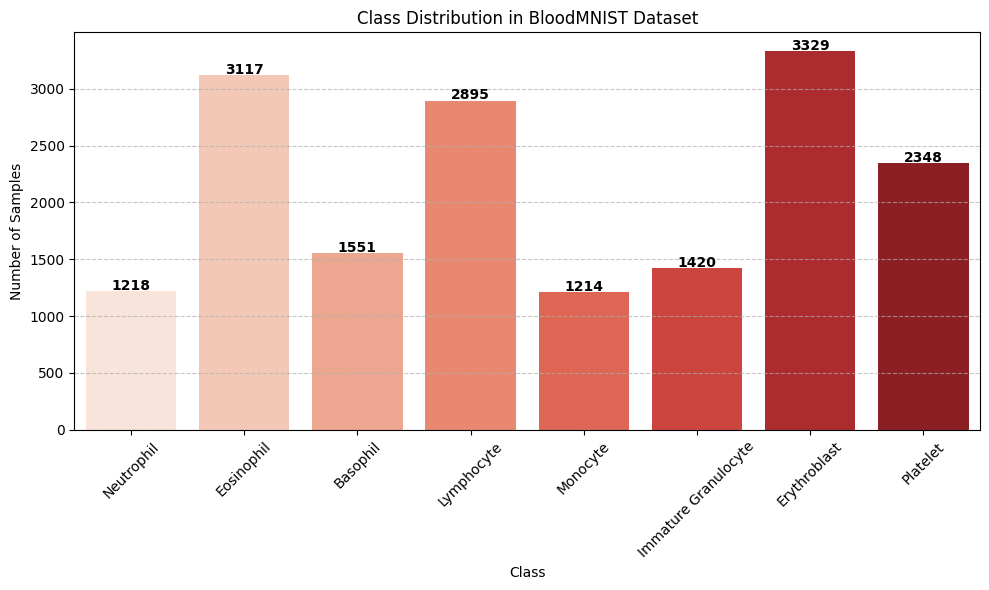

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Visualize class distribution across the full dataset (train + val + test)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all labels
y_all = np.concatenate([y_train_64, y_val_64, y_test_64]).flatten()

# Count samples per class
class_counts = Counter(y_all)

# Define class label names
class_names = [
    "Neutrophil", "Eosinophil", "Basophil", "Lymphocyte",
    "Monocyte", "Immature Granulocyte", "Erythroblast", "Platelet"
]

# Compute counts and percentages
counts = [class_counts[i] for i in range(len(class_names))]
percentages = [count / sum(counts) * 100 for count in counts]

# Print dataset stats
print(f"Total samples: {sum(counts)}")
print(f"Number of classes: {len(class_names)}")
print("\nSamples per class:")
for name, count, pct in zip(class_names, counts, percentages):
    print(f"{name:<25}: {count:>5} ({pct:.2f}%)")

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts, palette="Reds")
plt.title("Class Distribution in BloodMNIST Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add % text above each bar
for i, count in enumerate(counts):
    plt.text(i, count + 10, f"{counts[i]}", ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



## Visualize Sample Images

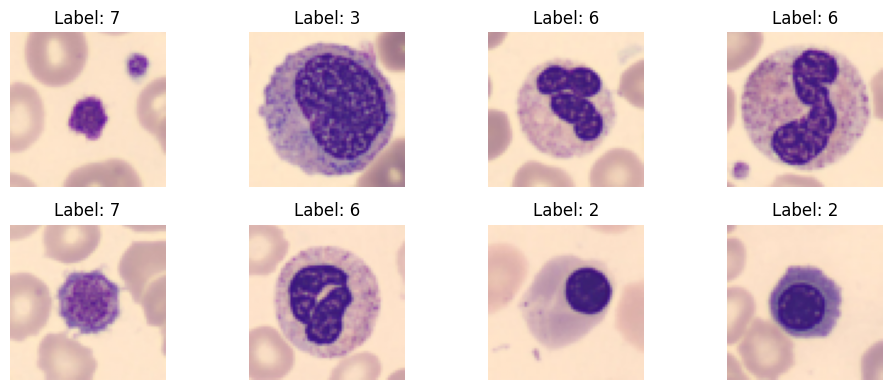

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train_64[i])
    plt.title(f"Label: {y_train_64[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# MODELS

## Overview of Implemented Models

### 1. Baseline CNN
A simple convolutional neural network with three Conv-BatchNorm-Pool blocks followed by fully connected layers. Used as a starting point for performance comparison.

### 2. Baseline CNN + Augmentation
Same architecture as the baseline CNN, but enhanced with real-time data augmentation (rotation, shift, zoom, flip) using `ImageDataGenerator` to improve generalization.

### 3. Inception CNN
Inspired by the Inception architecture, this model uses parallel convolutional paths with different kernel sizes to capture multi-scale features, followed by global average pooling.

### 4. Skip Connection CNN
A deeper CNN with residual (skip) connections that help preserve feature information and improve gradient flow, inspired by ResNet-style architectures.

### 5. Inception + Skip CNN (Hybrid)
Combines Inception blocks with skip connections to leverage both multi-scale feature extraction and improved information flow.

All models were trained on the BloodMNIST dataset (128×128 resolution), evaluated using accuracy, class-wise performance, and confusion matrices.


## Baseline CNN

## Baseline CNN Architecture (64×64)

This model serves as the starting point for blood cell image classification using 64×64 RGB inputs.

### Architecture Summary:
- **Input**: 64×64×3 RGB images
- **3 Convolutional Blocks**:
  - Each with Conv2D → BatchNorm → MaxPooling → Dropout
  - Filter sizes: 32, 64, and 128
  - Dropout rates: 0.25 → 0.3 (increasing with depth)
- **Fully Connected Layers**:
  - Flatten → Dense(128, ReLU) → Dropout(0.5)
  - Final Dense layer with 8 neurons (softmax) for classification
- **Total Output**: Probability distribution over 8 blood cell classes

### Compilation:
- **Optimizer**: Adam
- **Loss Function**: Sparse Categorical Crossentropy (for integer-encoded labels)
- **Metric**: Accuracy

This baseline model is regularized with dropout and well-suited for small to mid-size image classification tasks.


In [91]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_baseline_cnn(input_shape=(64, 64, 3), num_classes=8):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_baseline_64 = build_baseline_cnn()
model_baseline_64.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_baseline_64.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,880 (4.36 MB)

 Trainable params: 1,143,432 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

## Train the Model

## Model Training: Baseline CNN (64×64)

The baseline model was trained for up to 40 epochs with the following settings:

- **Batch Size**: 64
- **Validation Split**: Used a separate validation set
- **Early Stopping**: Applied to prevent overfitting
  - `patience=5`: Training stops if validation loss doesn't improve for 5 consecutive epochs
  - `restore_best_weights=True`: The model reverts to the best-performing weights on validation

This strategy ensures efficient training by halting once performance plateaus, while also preserving the most effective model state.


In [92]:
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history_baseline_64 = model_baseline_64.fit(
    X_train_64, y_train_64,
    validation_data=(X_val_64, y_val_64),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.5030 - loss: 1.8552 - val_accuracy: 0.1373 - val_loss: 36.5432
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7605 - loss: 0.6704 - val_accuracy: 0.1373 - val_loss: 32.5608
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8280 - loss: 0.4803 - val_accuracy: 0.3207 - val_loss: 7.0289
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8528 - loss: 0.4291 - val_accuracy: 0.8925 - val_loss: 0.3483
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8820 - loss: 0.3559 - val_accuracy: 0.3931 - val_loss: 5.6892
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8806 - loss: 0.3274 - val_accuracy: 0.6752 - val_loss: 1.7094
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9058 - loss: 0.2639 - val_accuracy: 0.6332 - val_loss: 2.3166
Epoch 8/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9052 - loss: 0.2652 - val_accuracy

## Plot Training History

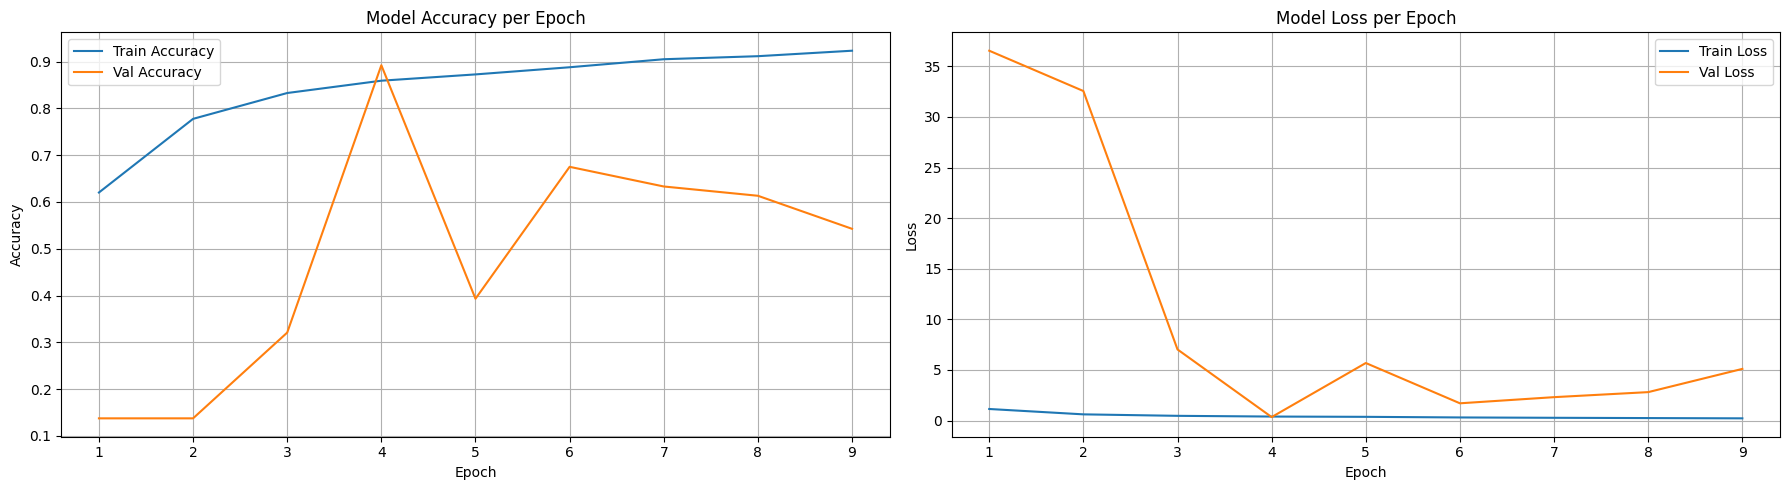

In [93]:
plot_training_diagnostics(history_baseline_64)

## Evaluate the Model on Test Set

In [94]:
test_loss, test_acc = model_baseline_64.evaluate(X_test_64, y_test_64)
print(f"Test Accuracy: {test_acc:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8649 - loss: 0.4074
Test Accuracy: 0.8708


## Confusion Matrix & Classification Report

In [95]:
class_accuracy(model_baseline_64, X_test_64, y_test_64, label_map)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy of Basophil: 95.08%
Accuracy of Eosinophil: 95.99%
Accuracy of Erythroblast: 75.88%
Accuracy of Immature granulocytes: 84.46%
Accuracy of Lymphocyte: 59.26%
Accuracy of Monocyte: 58.10%
Accuracy of Neutrophil: 96.70%
Accuracy of Platelet: 100.00%


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                       precision    recall  f1-score   support

             Basophil       0.79      0.95      0.87       244
           Eosinophil       1.00      0.96      0.98       624
         Erythroblast       0.98      0.76      0.86       311
Immature granulocytes       0.64      0.84      0.73       579
           Lymphocyte       0.97      0.59      0.73       243
             Monocyte       0.86      0.58      0.69       284
           Neutrophil       0.91      0.97      0.94       666
             Platelet       0.97      1.00      0.99       470

             accuracy                           0.87      3421
            macro avg       0.89      0.83      0.85      3421
         weighted avg       0.89      0.87      0.87      3421



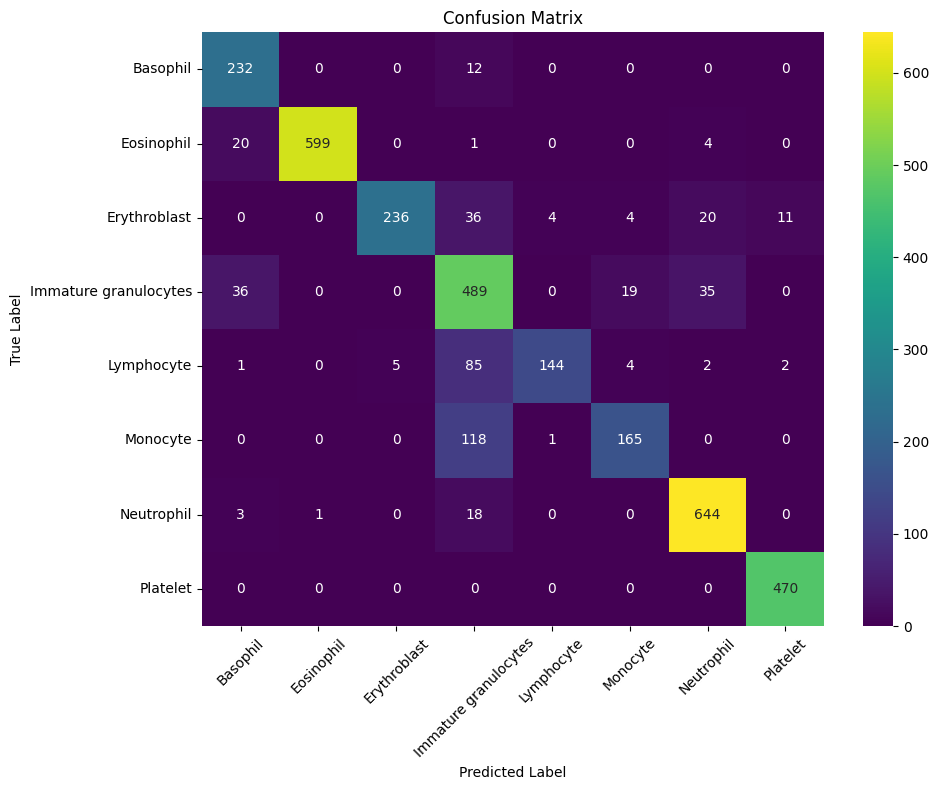

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred_baseline_64 = model_baseline_64.predict(X_test_64).argmax(axis=1)
y_true_baseline_64 = y_test_64

# Print classification report with class names
print(classification_report(y_true_baseline_64, y_pred_baseline_64, target_names=list(label_map.values())))

# Confusion matrix with class names
conf_matrix = confusion_matrix(y_true_baseline_64, y_pred_baseline_64)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


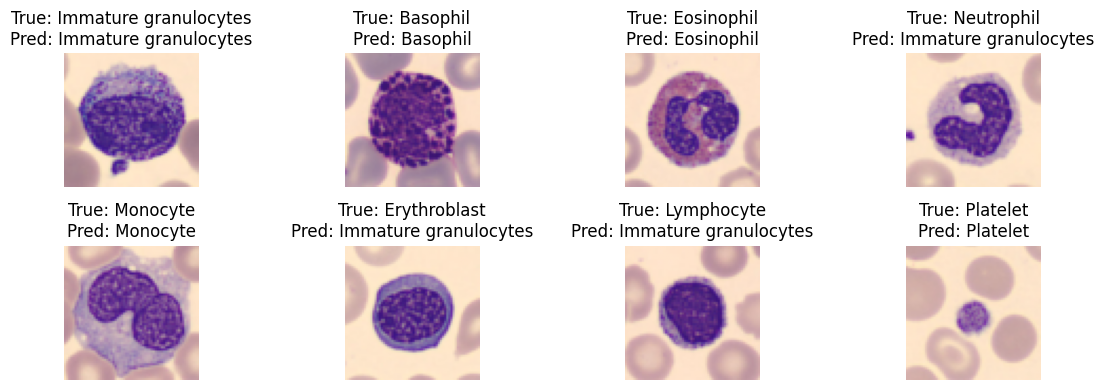

In [97]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Create a figure for displaying one image per class
plt.figure(figsize=(12, 4))

shown = set()
count = 0

for i in range(len(X_test_64)):
    label = y_test_64[i]
    if label not in shown:
        shown.add(label)
        image = X_test_64[i]
        true_label = label_map[label]
        pred_label = label_map[np.argmax(model_baseline_64.predict(image[None, ...]))]

        # Plot image with labels
        plt.subplot(2, 4, count + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
        count += 1

    if len(shown) == len(label_map):  # All 8 classes covered
        break

plt.tight_layout()
plt.show()



* Accuracy of Basophil: 95.08%
* Accuracy of Eosinophil: 95.99%
* Accuracy of Erythroblast: 75.88%
* Accuracy of Immature granulocytes: 84.46%
* Accuracy of Lymphocyte: 59.26%
* Accuracy of Monocyte: 58.10%
* Accuracy of Neutrophil: 96.70%
* Accuracy of Platelet: 100.00%

General acc:  0.87

## Model Evaluation: Baseline CNN (64×64)

The confusion matrix and classification report summarize the performance of the baseline CNN on the test set.

### Confusion Matrix
- Rows represent **true classes**, columns represent **predicted classes**.
- Most misclassifications occur between in the classes such as:
  - **Neutrophil ↔ Immature granulocytes**
  - **Erythroblast ↔ Immature granulocytes**
  - **Lymphocyte ↔ Immature granulocytes**

This highlights areas where the model could be improved with more training data or advanced architecture.

###  Classification Report
| Metric        | Description |
|---------------|-------------|
| **Precision** | Accuracy of positive predictions (low false positives) |
| **Recall**    | Coverage of actual class instances (low false negatives) |
| **F1-score**  | Harmonic mean of precision and recall |
| **Support**   | Number of true samples per class |

- **Platelet** has 100% and **Eosinophil** has 96%, **Neutrophil** has 97% and **Basophil** has 95%, achieve nearly perfect precision and recall.
- **Erythroblast, Immature granulocytes, Lymphocyte** and **Monocyte** show lower recall, indicating more frequent misclassification.

- **Overall Accuracy**: 87%
- **Macro Avg F1-score**: 0.89 → Indicates solid, balanced performance across classes.

This analysis helps identify strengths and weaknesses of the model and guides further tuning or architecture improvements.

As observed, the less frequent classes in the dataset tend to be more prone to misclassification.

# BASELINE CNN FOR 128x128

In [98]:
# Download dataset
!wget https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1 -O bloodmnist_128.npz

--2025-06-03 20:08:39--  https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569072780 (543M) [application/octet-stream]
Saving to: ‘bloodmnist_128.npz’

bloodmnist_128.npz  100%[===================>] 542.71M  17.6MB/s    in 35s     

2025-06-03 20:09:14 (15.6 MB/s) - ‘bloodmnist_128.npz’ saved [569072780/569072780]



## Data Loading and Preprocessing (128×128)

The BloodMNIST dataset (128×128 version) is loaded from a `.npz` archive and preprocessed as follows:

- **Images**:
  - Loaded from `train_images`, `val_images`, and `test_images`
  - Normalized by dividing pixel values by 255.0 to scale them to the `[0, 1]` range

- **Labels**:
  - Loaded from corresponding `train_labels`, `val_labels`, and `test_labels` fields
  - Flattened and converted to 32-bit integers for compatibility with TensorFlow models

- **Resulting Shapes** (example):
    * Train: (11959, 128, 128, 3)
    * Val: (1712, 128, 128, 3)
    * Test: (3421, 128, 128, 3)


This structured preprocessing ensures the data is clean, properly scaled, and formatted for training deep learning models.


In [99]:
import numpy as np

# Load data
data_128 = np.load("bloodmnist_128.npz")
X_train_128 = data_128['train_images'] / 255.0
X_val_128   = data_128['val_images'] / 255.0
X_test_128  = data_128['test_images'] / 255.0

y_train_128 = data_128['train_labels'].astype(np.int32).flatten()
y_val_128   = data_128['val_labels'].astype(np.int32).flatten()
y_test_128  = data_128['test_labels'].astype(np.int32).flatten()

print(f"Train: {X_train_128.shape}, Val: {X_val_128.shape}, Test: {X_test_128.shape}")


Train: (11959, 128, 128, 3), Val: (1712, 128, 128, 3), Test: (3421, 128, 128, 3)


## Baseline CNN Architecture (128×128)

This model builds on the same architecture used for 64×64 images, adapted for higher-resolution input (128×128).

### Architecture Summary:
- **Input**: 128×128×3 RGB images
- **Three Convolutional Blocks**:
  - Each block: `Conv2D → BatchNormalization → MaxPooling2D → Dropout`
  - Filter sizes: 32 → 64 → 128
  - Dropout rates: 0.25 → 0.25 → 0.30
- **Fully Connected Layers**:
  - `Flatten` to convert feature maps to a 1D vector
  - `Dense(128, ReLU)` for high-level representation
  - `Dropout(0.5)` for strong regularization
  - `Dense(8, softmax)` for classification over 8 blood cell classes

### Compilation:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss**: Sparse categorical crossentropy (for integer labels)
- **Metric**: Accuracy

This baseline model provides a solid reference point for comparison with more complex architectures like Inception and skip-connection CNNs.


In [100]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_baseline_cnn(input_shape=(128, 128, 3), num_classes=8):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_baseline_128 = build_baseline_cnn()
model_baseline_128.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_baseline_128.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,608 (16.36 MB)

 Trainable params: 4,289,160 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

## Model Training: Baseline CNN (128×128)

The model was trained on the 128×128 version of the BloodMNIST dataset using the following settings:

- **Epochs**: Up to 40 (early stopping may stop it earlier)
- **Batch Size**: 64
- **Validation Set**: Used for monitoring performance
- **EarlyStopping Callback**:
  - `patience=5`: Stops training if validation loss does not improve for 5 consecutive epochs
  - `restore_best_weights=True`: Restores model weights from the epoch with the best validation performance

This setup helps avoid overfitting and ensures the final model represents the best generalization performance observed during training.


In [101]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history_baseline_128 = model_baseline_128.fit(
    X_train_128, y_train_128,
    validation_data=(X_val_128, y_val_128),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.4959 - loss: 2.9953 - val_accuracy: 0.1373 - val_loss: 119.0270
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7104 - loss: 0.8355 - val_accuracy: 0.1373 - val_loss: 38.2840
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7688 - loss: 0.6662 - val_accuracy: 0.3026 - val_loss: 8.7670
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8022 - loss: 0.5622 - val_accuracy: 0.8435 - val_loss: 0.4570
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8288 - loss: 0.4722 - val_accuracy: 0.5350 - val_loss: 2.2200
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8366 - loss: 0.4745 - val_accuracy: 0.9071 - val_loss: 0.3194
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8456 - loss: 0.4458 - val_accuracy: 0.8534 - val_loss: 0.5454
Epoch 8/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8726 - loss: 0.3508 - val_

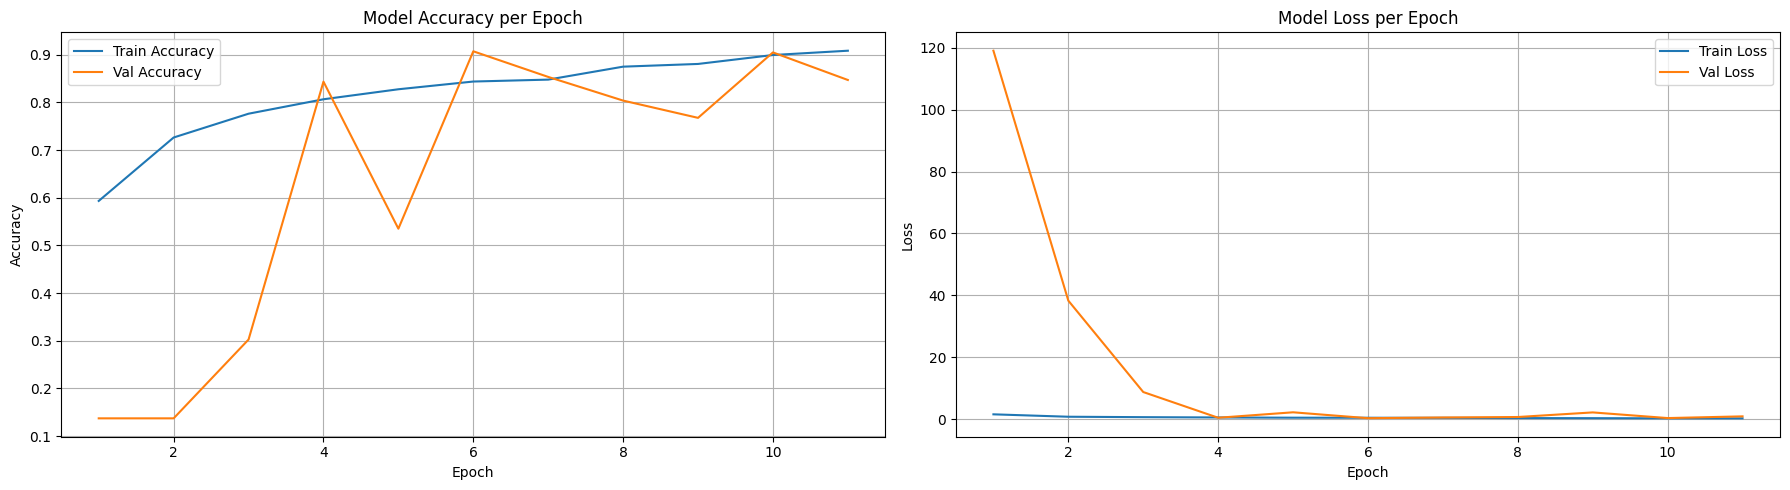

In [102]:
plot_training_diagnostics(history_baseline_128)

In [103]:
test_loss_baseline_128, test_acc_baseline_128 = model_baseline_128.evaluate(X_test_128, y_test_128)
print(f"Test Accuracy: {test_acc_baseline_128:.4f}")


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8909 - loss: 0.3992
Test Accuracy: 0.8962


In [104]:
class_accuracy(model_baseline_128, X_test_128, y_test_128, label_map)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy of Basophil: 94.67%
Accuracy of Eosinophil: 99.84%
Accuracy of Erythroblast: 91.64%
Accuracy of Immature granulocytes: 83.07%
Accuracy of Lymphocyte: 81.48%
Accuracy of Monocyte: 56.69%
Accuracy of Neutrophil: 93.39%
Accuracy of Platelet: 98.94%


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                       precision    recall  f1-score   support

             Basophil       0.80      0.95      0.87       244
           Eosinophil       0.94      1.00      0.97       624
         Erythroblast       0.93      0.92      0.92       311
Immature granulocytes       0.73      0.83      0.78       579
           Lymphocyte       0.97      0.81      0.88       243
             Monocyte       0.93      0.57      0.70       284
           Neutrophil       0.95      0.93      0.94       666
             Platelet       1.00      0.99      0.99       470

             accuracy                           0.90      3421
            macro avg       0.90      0.87      0.88      3421
         weighted avg       0.90      0.90      0.89      3421



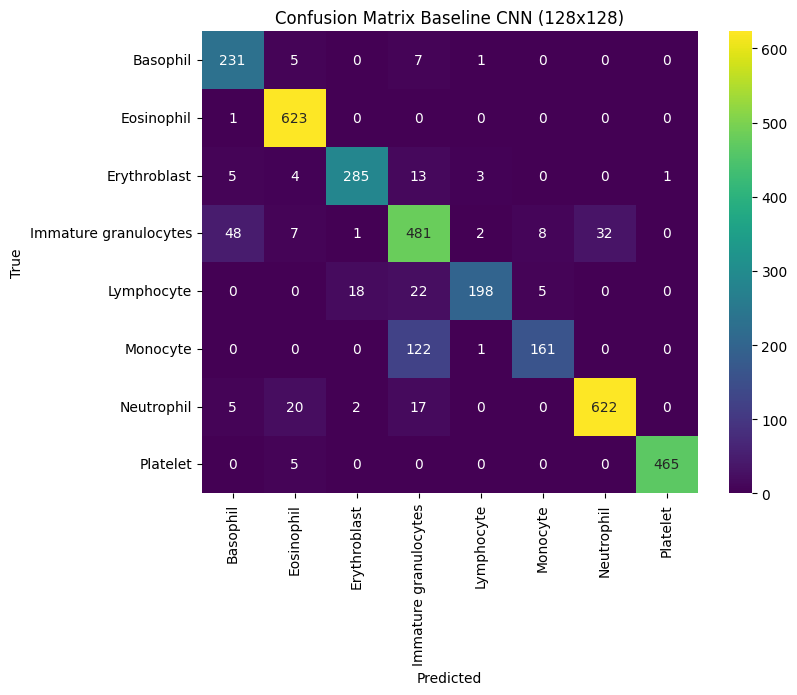

In [133]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_baseline_128 = model_baseline_128.predict(X_test_128).argmax(axis=1)
print(classification_report(y_test_128, y_pred_baseline_128, target_names=list(label_map.values())))


conf_matrix_baseline_128 = confusion_matrix(y_test_128, y_pred_baseline_128)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_baseline_128, annot=True, fmt="d", cmap="viridis",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix Baseline CNN (128x128)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Evaluation Results: Baseline CNN (128×128)

The confusion matrix and classification report show improved performance over the 64×64 version, especially in class-level precision and recall.

### Confusion Matrix Highlights
- Most predictions are correctly classified along the diagonal.
- **Common misclassifications**:
  - **Basophils** often confused with **Immature granulocytes**.
  - **Monocytes** and **Immature granulocytes** have some overlap.
  - **Neutrophils** show strong classification but with some confusion toward **Immature granulocytes**.

### Classification Report Summary
| Metric        | Value |
|---------------|--------|
| **Overall Accuracy**    | 90% |
| **Macro Avg F1-score**  | 0.88 |
| **Weighted Avg F1-score** | 0.89 |

### Class-level Insights
- **Nearly perfect scores** for **Eosinophil** and **Platelet** (precision, recall, F1 = 1.00, 0.99 respectively).
- **Erythroblast** recall improved from 76% (64×64) to **92%**, precision at **93%**.
- **Immature granulocytes**: Higher recall (**83%**), but lower precision (**73%**), indicating more false positives.
- **Monocyte**: Slight drop in recall (**57%**), indicating more frequent confusion.

Overall, increasing the input resolution to 128×128 improves the model’s ability to distinguish finer cellular features, leading to stronger performance across most classes. However, classes in the dataset that are less frequent still tend to be more prone to misclassification.

# ENHANCED BASELINE CNN

## Baseline CNN with Data Augmentation (128×128)

This model uses the same architecture as the baseline CNN, but incorporates **real-time data augmentation** to improve generalization and reduce overfitting.

### Data Augmentation Techniques
Implemented using `ImageDataGenerator`, the training images are randomly transformed at each epoch using:
- **Rotation**: ±5 degrees
- **Width & Height Shift**: Up to 5%
- **Zoom**: Up to 5%
- **Horizontal Flip**: Random mirroring

These augmentations simulate variability in microscopic imaging conditions and increase the effective diversity of the training set.

### CNN Architecture
- Identical to the baseline CNN:
  - 3 convolutional blocks with increasing filters (32 → 64 → 128)
  - Batch normalization, max pooling, and dropout for regularization
  - Fully connected layers with a softmax output for 8-class classification

### Purpose
The goal of this setup is to:
- Expose the model to more diverse training patterns
- Improve robustness to minor shifts, rotations, and distortions
- Potentially enhance class-wise accuracy, especially for underrepresented or confusing classes

This setup retains the simplicity of the baseline CNN while boosting its ability to generalize.



In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

# Fit generator to training data
#datagen.fit(X_train_128)


Let's see some samples images:

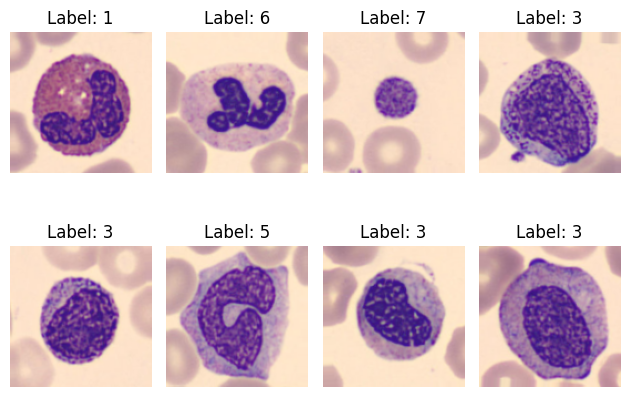

In [107]:
for X_batch, y_batch in datagen.flow(X_train_128, y_train_128, batch_size=8):
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(X_batch[i])
        plt.title(f"Label: {y_batch[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break


In [108]:
from tensorflow.keras import layers, models, callbacks

def build_baseline_cnn(input_shape=(128, 128, 3), num_classes=8):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Instantiate and compile
model_aug = build_baseline_cnn()
model_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_aug.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,608 (16.36 MB)

 Trainable params: 4,289,160 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

## Training with Data Augmentation and Early Stopping

The model was trained using real-time data augmentation and an early stopping mechanism to improve generalization and avoid overfitting.

### Training Details
- **Input**: Augmented batches generated by `ImageDataGenerator`
- **Batch Size**: 64
- **Epochs**: Up to 40
- **Validation Data**: Used for performance monitoring

### Early Stopping
- `patience=5`: Stops training if validation loss does not improve for 5 consecutive epochs
- `restore_best_weights=True`: Automatically restores the best weights from training

### Benefits
- Encourages better generalization by exposing the model to varied, realistic inputs
- Prevents overfitting by stopping training at the optimal point


In [130]:
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history_aug = model_aug.fit(
    datagen.flow(X_train_128, y_train_128, batch_size=64),
    validation_data=(X_val_128, y_val_128),
    epochs=40,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.7744 - loss: 0.6206 - val_accuracy: 0.5251 - val_loss: 1.8727
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.8105 - loss: 0.5600 - val_accuracy: 0.6560 - val_loss: 1.5718
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.8234 - loss: 0.5250 - val_accuracy: 0.3633 - val_loss: 13.4248
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.8400 - loss: 0.4866 - val_accuracy: 0.4089 - val_loss: 2.2505
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.8516 - loss: 0.4510 - val_accuracy: 0.4591 - val_loss: 4.9699
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.8610 - loss: 0.4281 - val_accuracy: 0.9317 - val_loss: 0.2596
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.8712 - loss: 0.3793 - val_accuracy: 0.7932 - val_loss: 1.0425
Epoch 8/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.8772 - loss: 

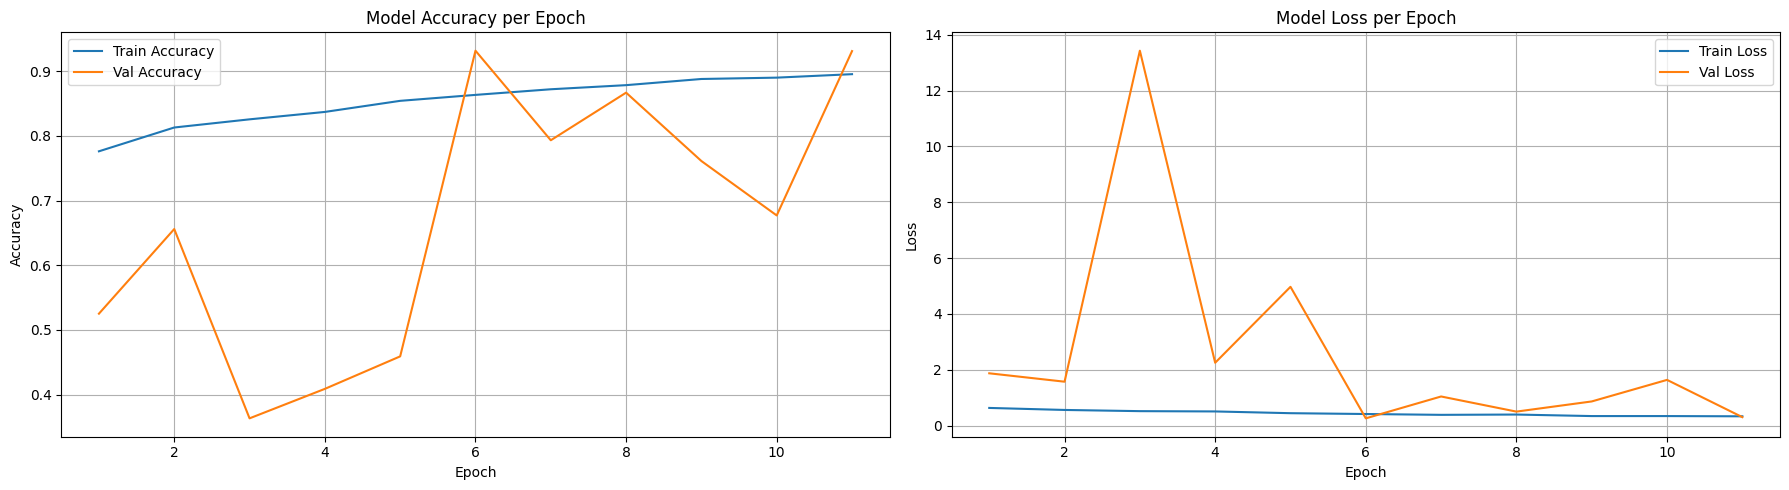

In [139]:
plot_training_diagnostics(history_aug)

In [140]:
test_loss_aug_128, test_acc_aug_128 = model_aug.evaluate(X_test_128, y_test_128)
print(f"Test Accuracy: {test_acc_aug_128:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9099 - loss: 0.3011
Test Accuracy: 0.9193


In [141]:
class_accuracy(model_aug, X_test_128, y_test_128, label_map)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy of Basophil: 83.20%
Accuracy of Eosinophil: 99.84%
Accuracy of Erythroblast: 95.50%
Accuracy of Immature granulocytes: 81.87%
Accuracy of Lymphocyte: 91.77%
Accuracy of Monocyte: 93.31%
Accuracy of Neutrophil: 88.74%
Accuracy of Platelet: 99.79%


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                       precision    recall  f1-score   support

             Basophil       0.98      0.83      0.90       244
           Eosinophil       1.00      1.00      1.00       624
         Erythroblast       0.91      0.95      0.93       311
Immature granulocytes       0.78      0.82      0.80       579
           Lymphocyte       0.98      0.92      0.95       243
             Monocyte       0.74      0.93      0.83       284
           Neutrophil       0.98      0.89      0.93       666
             Platelet       1.00      1.00      1.00       470

             accuracy                           0.92      3421
            macro avg       0.92      0.92      0.92      3421
         weighted avg       0.93      0.92      0.92      3421



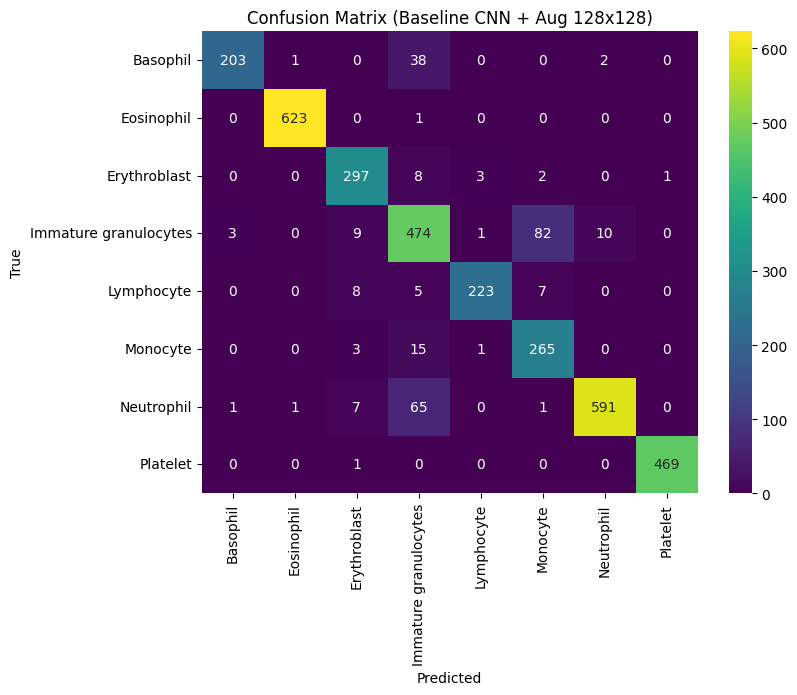

In [142]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_aug_128 = model_aug.predict(X_test_128).argmax(axis=1)
print(classification_report(y_test_128, y_pred_aug_128, target_names=list(label_map.values())))

conf_matrix_128 = confusion_matrix(y_test_128, y_pred_aug_128)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_128, annot=True, fmt="d", cmap="viridis",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix (Baseline CNN + Aug 128x128)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Evaluation: Baseline CNN with Data Augmentation (128×128)

The confusion matrix and classification report reflect the performance gains achieved by applying data augmentation during training.

### Confusion Matrix Insights
- Better distribution of correct predictions across most classes
- Reduced confusion between **Monocyte**, **Immature granulocytes**, and **Neutrophil**
- Slight reduced classification in **Basophil** and **Erythroblast** compared to the non-augmented baseline
- Overall, better performance compared to the non-augmented baseline

### Classification Report Summary
| Metric         | Value |
|----------------|--------|
| **Overall Accuracy**        | 92% |
| **Macro Average F1-score**  | 0.92 |
| **Weighted Average F1-score** | 0.93 |

### Class-wise Highlights

- **Eosinophil & Platelet**: Perfect performance for both (F1 = **1.00**)
- **Immature granulocytes**: Recall increased to **82%**, though some confusion remains with Neutrophil and Basophil
- **Monocyte & Lymphocyte**: Both show **balanced precision/recall** and improved F1-scores
- **Neutrophil**: Slight trade-off in recall, but overall still strong performance

### Summary
Data augmentation led to **clear improvements in generalization**, especially in class-level recall and F1-scores, while maintaining high overall accuracy. It’s particularly effective in reducing misclassifications between morphologically similar blood cells.


Due to diminishing returns and resource constraints, I did not upscale to dataset resolution to 256×256 and all the experiments were conducted for a *128x128 resolution dataset.*


# Augmented Training with Simplified U-Net-Inspired CNN

## Simplified U-Net-Inspired CNN (Encoder-Only)

This model adapts the **encoder part of a U-Net architecture** for classification purposes. While U-Net is typically used for segmentation, this simplified version uses its **multi-resolution feature extraction** structure for classifying blood cell images.

### Architecture Overview
- **Input**: 128×128×3 RGB images
- **Encoder Blocks**:
  - 3 convolutional blocks with increasing filters: 32 → 64 → 128
  - Each block contains:
    - `Conv2D` + `BatchNormalization`
    - `MaxPooling2D` to downsample
    - Increasing dropout rates for regularization: 0.1 → 0.15 → 0.2
- **Classification Head**:
  - `Flatten` the features
  - `Dense(64, ReLU)` fully connected layer
  - `Dropout(0.3)`
  - `Dense(8, softmax)` output for 8-class classification

###  Purpose
- Mimics the **feature-compression path** of U-Net
- Focuses on **deep hierarchical feature extraction**
- Lightweight and computationally efficient alternative to deeper CNNs

This model leverages the spatial abstraction capabilities of U-Net’s encoder while simplifying the architecture for classification rather than segmentation.


In [114]:
# Step 2: Define a Simple U-Net-Inspired CNN
from tensorflow.keras import layers, models

def build_simplified_unet_encoder(input_shape=(128, 128, 3), num_classes=8):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.1),

        # Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.15),

        # Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.2),

        # Classification Head
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


## Training the Simplified U-Net-Inspired CNN

This model was trained using advanced strategies to improve generalization, especially on underrepresented classes.

### Training Setup
- **Optimizer**: Adam
- **Loss Function**: Sparse categorical crossentropy (suitable for integer labels)
- **Metrics**: Accuracy
- **Batch Size**: 64
- **Epochs**: Up to 40

### Class Weighting
To address **class imbalance**, class weights were computed using `compute_class_weight('balanced')` and applied during training. This ensures the model pays more attention to underrepresented classes.

### Data Augmentation
Training data was augmented using:
- Rotation, shift, zoom, and horizontal flip
- Implemented with `ImageDataGenerator`

### Callbacks
- **EarlyStopping**:
  - `patience=5`
  - Stops training early if validation loss doesn't improve
  - Restores the best-performing weights
- **ReduceLROnPlateau**:
  - Monitors validation loss
  - Reduces the learning rate by half if the model plateaus for 3 epochs
  - Helps escape local minima and improve convergence

This training configuration combines data diversity, class rebalancing, and adaptive learning for better performance and stability.


In [115]:
#Compile and Train
from tensorflow.keras import callbacks
from sklearn.utils.class_weight import compute_class_weight

model_simplified = build_simplified_unet_encoder()
model_simplified.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_128), y=y_train_128)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)



# Callbacks
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train with augmentation
history_simplified = model_simplified.fit(
    datagen.flow(X_train_128, y_train_128, batch_size=64),
    validation_data=(X_val_128, y_val_128),
    epochs=40,
    callbacks=[early_stop, lr_schedule],
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 239ms/step - accuracy: 0.2842 - loss: 3.0929 - val_accuracy: 0.0853 - val_loss: 29.4318 - learning_rate: 0.0010
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.5311 - loss: 1.3436 - val_accuracy: 0.0771 - val_loss: 24.7279 - learning_rate: 0.0010
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.6442 - loss: 1.0741 - val_accuracy: 0.2442 - val_loss: 11.9138 - learning_rate: 0.0010
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.6419 - loss: 0.9743 - val_accuracy: 0.6630 - val_loss: 1.1125 - learning_rate: 0.0010
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.6557 - loss: 0.8742 - val_accuracy: 0.6951 - val_loss: 0.9342 - learning_rate: 0.0010
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.7109 - loss: 0.7643 - val_accuracy: 0.5362 - val_loss: 4.8572 - learning_rate: 0.0010
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 

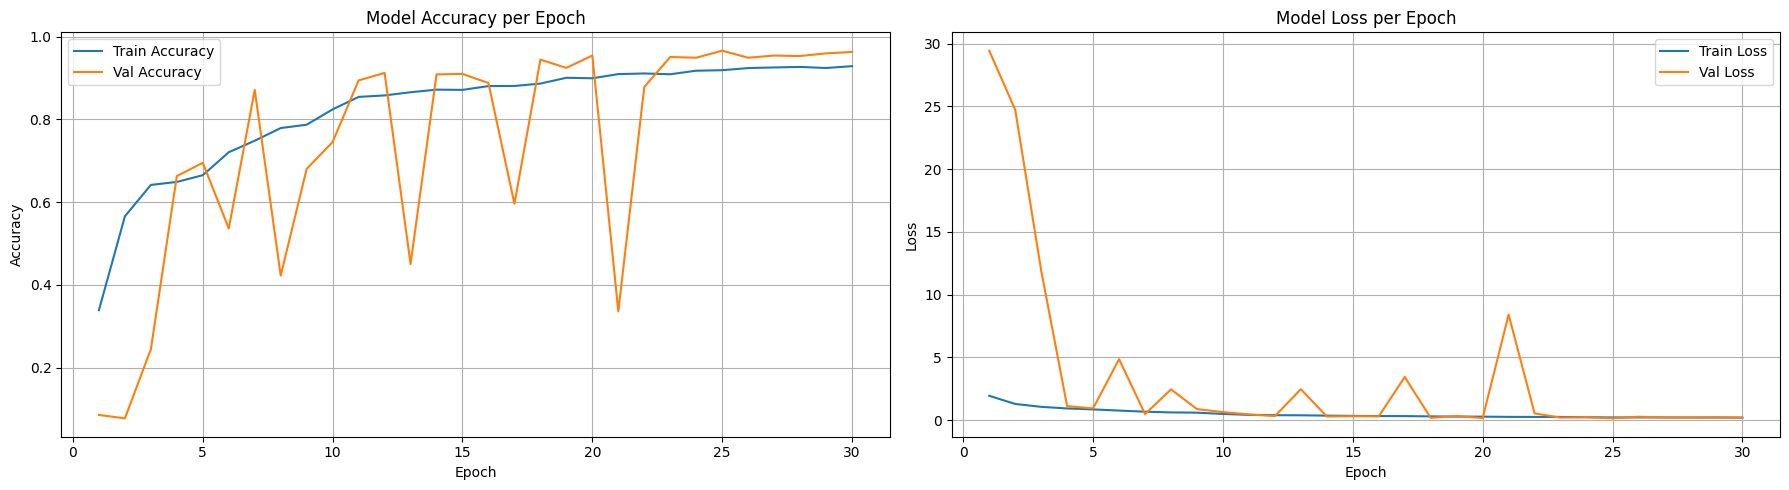

In [116]:
plot_training_diagnostics(history_simplified)

In [117]:
# Step 4: Evaluate + Plot Results
test_loss_simplified, test_acc_simplified = model_simplified.evaluate(X_test_128, y_test_128)
print(f"Test Accuracy: {test_acc_simplified:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9637 - loss: 0.1313
Test Accuracy: 0.9646


In [118]:
class_accuracy(model_simplified, X_test_128, y_test_128, label_map)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy of Basophil: 98.77%
Accuracy of Eosinophil: 99.84%
Accuracy of Erythroblast: 97.11%
Accuracy of Immature granulocytes: 91.36%
Accuracy of Lymphocyte: 96.71%
Accuracy of Monocyte: 94.01%
Accuracy of Neutrophil: 95.05%
Accuracy of Platelet: 100.00%


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
                       precision    recall  f1-score   support

             Basophil       0.94      0.99      0.96       244
           Eosinophil       1.00      1.00      1.00       624
         Erythroblast       0.98      0.97      0.98       311
Immature granulocytes       0.90      0.91      0.91       579
           Lymphocyte       0.98      0.97      0.97       243
             Monocyte       0.94      0.94      0.94       284
           Neutrophil       0.97      0.95      0.96       666
             Platelet       1.00      1.00      1.00       470

             accuracy                           0.96      3421
            macro avg       0.96      0.97      0.97      3421
         weighted avg       0.96      0.96      0.96      3421



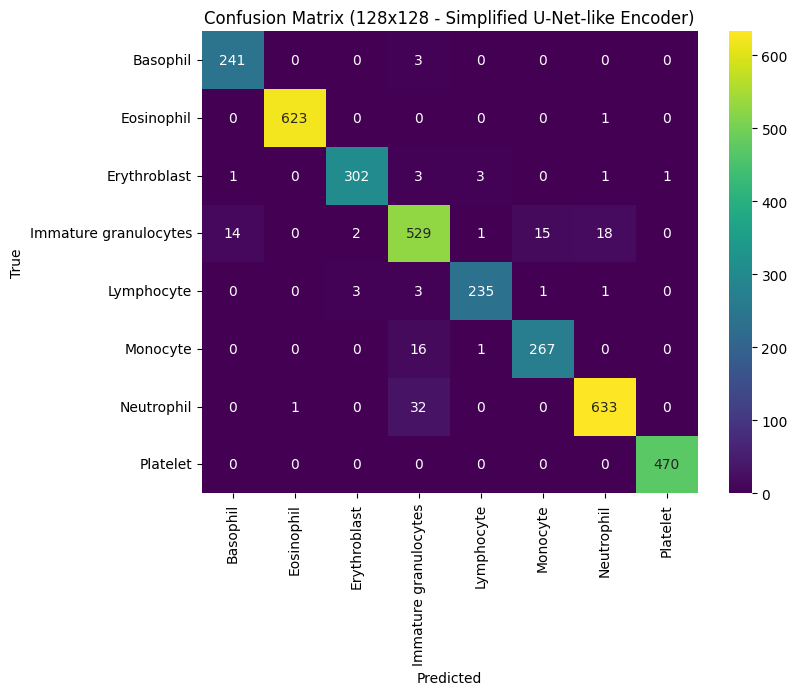

In [135]:
# Step 5: Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_simplied = model_simplified.predict(X_test_128).argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_test_128, y_pred_simplied,target_names=list(label_map.values())))

conf_matrix = confusion_matrix(y_test_128, y_pred_simplied)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix (128x128 - Simplified U-Net-like Encoder)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Evaluation: Simplified U-Net-Inspired CNN (128×128)

The confusion matrix and classification report show that this architecture achieves **strong overall performance**, benefiting from hierarchical feature extraction and class weighting.

### Confusion Matrix Insights
- Very few major misclassifications
- Most confusion occurs between:
  - **Immature granulocytes** vs. **Neutrophil** or **Monocyte**
- Almost perfect classification for **Eosinophil** and **Platelet** (recall=1.00)


### Classification Report Summary
| Metric         | Value |
|----------------|--------|
| **Overall Accuracy**        | 96% |
| **Macro Average F1-score**  | 0.97 |
| **Weighted Average F1-score** | 0.96 |

### Class-wise Performance
- **Basophil**: Precision & recall both at 99%
- **Eosinophil & Platelet**: Perfect or near-perfect (F1 = 1.00)
- **Immature granulocytes**: Slightly lower recall (91%), likely due to overlap with Monocyte/Lymphocyte
- **Monocyte**: Very strong performance (F1 = 0.94)
- **Neutrophil**: Balanced precision and recall (96%)

### Summary
This encoder-only U-Net-style model achieves **highly competitive results** with fewer parameters than deeper architectures. Its strong performance across all classes shows that well-structured, efficient architectures can rival more complex alternatives when trained with augmentation and proper balancing.


# Inception CNN

## Inception-Based CNN Architecture (128×128)

This model incorporates **Inception blocks**, inspired by the GoogLeNet/Inception architecture, to extract multi-scale features from blood cell images.

### Key Design Features

- **Input**: 128×128×3 RGB images

- **Initial Convolution Layer**:
  - A standard `Conv2D` layer followed by max pooling to reduce spatial size.

- **Inception Blocks**:
  - Two stacked blocks with multi-path convolutions to capture features at multiple scales.
  - Each Inception block combines:
    - 1×1 convolution (low-complexity features)
    - 3×3 and 5×5 convolutions (spatial context)
    - 3×3 max-pooling followed by 1×1 projection
    - All outputs are concatenated to preserve detail at different resolutions.

- **Downsampling**:
  - Each Inception block is followed by `MaxPooling2D` to reduce spatial dimensions.

- **Classification Head**:
  - `GlobalAveragePooling2D`: Replaces flattening to reduce overfitting
  - `Dense(64, ReLU)` layer + `Dropout(0.3)`
  - Final `Dense(num_classes, softmax)` for class prediction

### Purpose & Advantages
- **Multi-scale feature extraction** improves the model’s ability to distinguish subtle differences between cell types.
- More expressive than sequential CNNs while still maintaining good parameter efficiency.
- **Global average pooling** helps generalization and reduces model complexity.

This architecture strikes a strong balance between performance and flexibility, and is particularly effective in complex image classification tasks like blood cell type prediction.


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


# Inception Block
def inception_block(x, filters):
    f1, f3_in, f3_out, f5_in, f5_out, proj = filters

    path1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    path1 = layers.BatchNormalization()(path1)

    path2 = layers.Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3_out, (3, 3), padding='same', activation='relu')(path2)
    path2 = layers.BatchNormalization()(path2)

    path3 = layers.Conv2D(f5_in, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5_out, (5, 5), padding='same', activation='relu')(path3)
    path3 = layers.BatchNormalization()(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(proj, (1, 1), padding='same', activation='relu')(path4)
    path4 = layers.BatchNormalization()(path4)

    return layers.concatenate([path1, path2, path3, path4], axis=-1)

# Build Inception Model
def build_inception_cnn(input_shape=(128, 128, 3), num_classes=8):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = inception_block(x, [16, 16, 24, 4, 8, 8])
    x = layers.MaxPooling2D(2)(x)

    x = inception_block(x, [32, 32, 48, 8, 16, 16])
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

## Training the Inception-Based CNN

The Inception model was compiled and trained on the 128×128 BloodMNIST dataset using a carefully tuned setup to enhance convergence and generalization.

### Compilation Settings
- **Optimizer**: Adam with a learning rate of `1e-4`
- **Loss Function**: Sparse categorical crossentropy (suitable for integer-encoded labels)
- **Evaluation Metric**: Accuracy

### Callbacks Used
- **EarlyStopping**:
  - Monitors validation loss
  - `patience=5`: Stops training early if no improvement is seen for 5 epochs
  - Restores the best weights to avoid overfitting
- **ReduceLROnPlateau**:
  - Monitors validation loss
  - Reduces the learning rate by a factor of 0.5 after 3 stagnant epochs
  - Helps fine-tune the model during later training stages

### Training Configuration
- **Epochs**: Up to 40
- **Batch Size**: 64
- **Validation Data**: Used for real-time monitoring of generalization

This training strategy enables the Inception model to learn effectively while dynamically adapting to validation performance and minimizing overfitting.




In [47]:
# Compile and Train
model_inception = build_inception_cnn()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model_inception.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


history_inception = model_inception.fit(
    X_train_128, y_train_128,
    validation_data=(X_val_128, y_val_128),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.3453 - loss: 1.8027 - val_accuracy: 0.1945 - val_loss: 2.1027 - learning_rate: 1.0000e-04
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6912 - loss: 1.0538 - val_accuracy: 0.1951 - val_loss: 2.0261 - learning_rate: 1.0000e-04
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7745 - loss: 0.7560 - val_accuracy: 0.7763 - val_loss: 1.2741 - learning_rate: 1.0000e-04
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8369 - loss: 0.5862 - val_accuracy: 0.7570 - val_loss: 0.7873 - learning_rate: 1.0000e-04
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8642 - loss: 0.4831 - val_accuracy: 0.9182 - val_loss: 0.3816 - learning_rate: 1.0000e-04
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8825 - loss: 0.4117 - val_accuracy: 0.9346 - val_loss: 0.3084 - learning_rate: 1.0000e-04
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - a

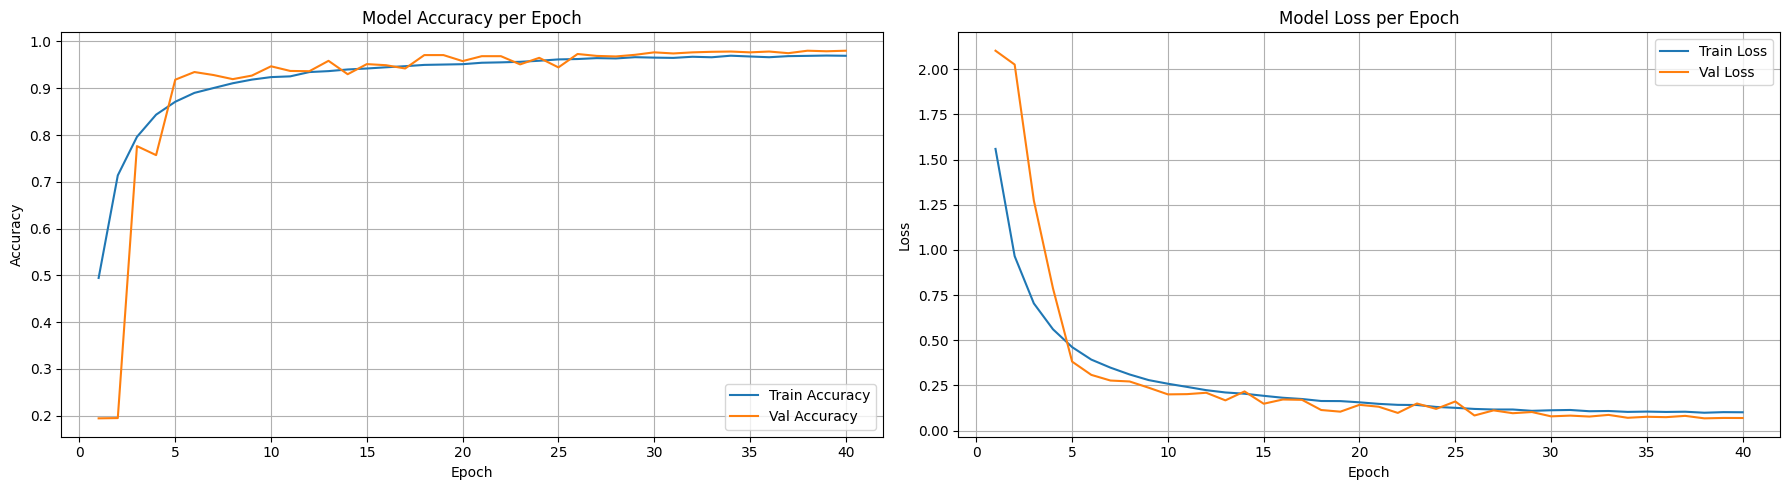

In [48]:
plot_training_diagnostics(history_inception)

In [49]:
# Evaluate
test_loss_inception, test_acc_inception = model_inception.evaluate(X_test_128, y_test_128)
print(f"\n Test Accuracy: {test_acc_inception:.4f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9790 - loss: 0.0771

 Test Accuracy: 0.9787


In [50]:
class_accuracy(model_inception, X_test_128, y_test_128, label_map)

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Accuracy of Basophil: 97.54%
Accuracy of Eosinophil: 99.84%
Accuracy of Erythroblast: 98.71%
Accuracy of Immature granulocytes: 95.85%
Accuracy of Lymphocyte: 99.18%
Accuracy of Monocyte: 96.13%
Accuracy of Neutrophil: 96.25%
Accuracy of Platelet: 100.00%


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                       precision    recall  f1-score   support

             Basophil       0.98      0.98      0.98       244
           Eosinophil       1.00      1.00      1.00       624
         Erythroblast       0.99      0.99      0.99       311
Immature granulocytes       0.94      0.96      0.95       579
           Lymphocyte       0.99      0.99      0.99       243
             Monocyte       0.99      0.96      0.98       284
           Neutrophil       0.97      0.96      0.97       666
             Platelet       1.00      1.00      1.00       470

             accuracy                           0.98      3421
            macro avg       0.98      0.98      0.98      3421
         weighted avg       0.98      0.98      0.98      3421



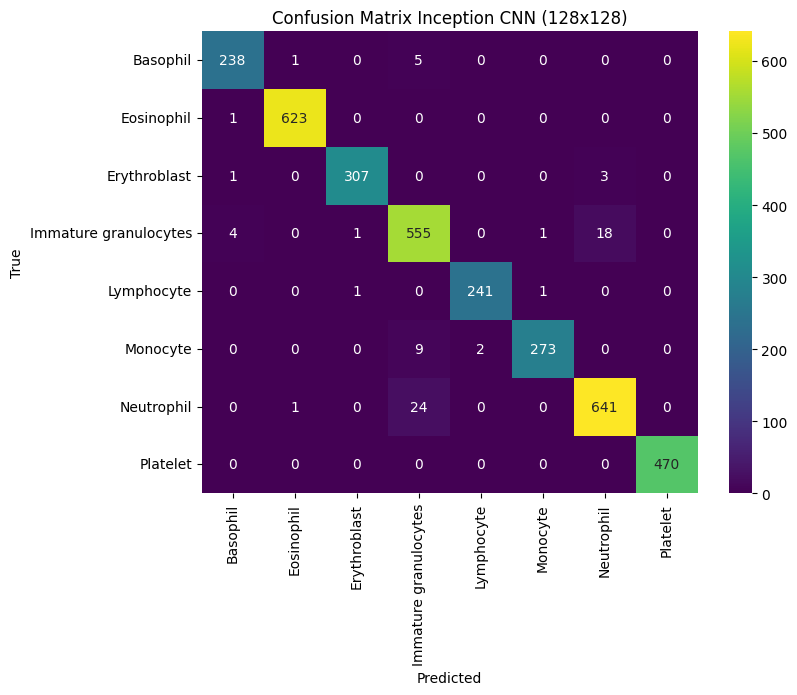

In [136]:
# Classification Report & Confusion Matrix
y_pred_incepiton = model_inception.predict(X_test_128).argmax(axis=1)
print(classification_report(y_test_128, y_pred_incepiton,target_names=list(label_map.values())))

conf_matrix = confusion_matrix(y_test_128, y_pred_incepiton)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix Inception CNN (128x128)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Evaluation: Inception-Based CNN (128×128)

The confusion matrix and classification report show that the Inception model performs exceptionally well, particularly in handling inter-class variations with multi-scale feature extraction.

### Confusion Matrix Observations
- Predictions are highly accurate across all classes with minimal misclassification.
- **Most confusion occurs within similar cell types**, such as:
  - **Immature granulocytes ↔ Neutrophil**
  - **Monocyte ↔ Immature granulocytes**
  However, compared to other models confusion is less.
- Class 1 (Eosinophil) and Class 7 (Platelet) are perfectly classified.

### Classification Report Summary
| Metric         | Value |
|----------------|--------|
| **Overall Accuracy**        | 98% |
| **Macro Average F1-score**  | 0.98 |
| **Weighted Average F1-score** | 0.98 |

### Class-wise Highlights
- **Eosinophil & Platelet**: Precision, recall, and F1-score = **1.00**
- **Basophil**: Precision = 0.98, Recall = 0.98 → excellent improvement
- **Monocyte & Immature granulocytes**: Slight confusion, but still strong with F1-scores of 0.98 and 0.95, respectively.
- **Lymphocyte**: Near perfect recall and high F1-score = 0.99

### Summary
The Inception architecture achieves **top-tier accuracy and generalization**, benefiting from its ability to extract diverse spatial features at multiple scales. It demonstrates consistent, balanced performance across all blood cell classes with nearly perfect classification for most.


# Skip connection CNN

## Skip Connection CNN (ResNet-Inspired, 128×128)

This model incorporates **residual (skip) connections**, inspired by ResNet, to improve gradient flow, stabilize training, and preserve learned features across layers.

### Architecture Overview

- **Input**: 128×128×3 RGB image

- **Block 1**:
  - Two Conv2D layers with 32 filters + BatchNorm
  - Output pooled to (64×64×32)

- **Block 2 (with Skip Connection)**:
  - Two Conv2D layers with 64 filters + BatchNorm
  - Residual connection: input projection using `Conv2D(1x1)` to match dimensions
  - Element-wise addition (`layers.add`) combines the shortcut with the main path
  - Output pooled to (32×32×64)

- **Block 3 (with Skip Connection)**:
  - Two Conv2D layers with 128 filters + BatchNorm
  - Another residual connection with projection to match channels
  - Element-wise addition merges input and output features

- **Classification Head**:
  - `GlobalAveragePooling2D` to reduce spatial dimensions
  - `Dense(64, ReLU)` followed by `Dropout(0.3)`
  - Final `Dense(8, softmax)` for multiclass classification

###  Key Advantages
- **Skip connections** improve:
  - **Gradient propagation** (mitigating vanishing gradients)
  - **Feature reuse** (preserving earlier features)
  - **Training stability** in deeper architectures
- Uses **residual learning** without dramatically increasing complexity

This architecture offers a solid balance between performance and depth, making it more robust than purely sequential CNNs.


In [52]:
def build_skip_connection_cnn(input_shape=(128, 128, 3), num_classes=8):
    inputs = layers.Input(shape=input_shape)

    x1 = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(32, 3, padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    p1 = layers.MaxPooling2D(2)(x1)  # (64, 64, 32)

    x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(p1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)

    # Match p1's channels to x2's using a 1x1 Conv2D
    p1_proj = layers.Conv2D(64, (1, 1), padding='same')(p1)
    skip1 = layers.add([p1_proj, x2])
    p2 = layers.MaxPooling2D(2)(skip1)  # (32, 32, 64)

    x3 = layers.Conv2D(128, 3, padding='same', activation='relu')(p2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Conv2D(128, 3, padding='same', activation='relu')(x3)
    x3 = layers.BatchNormalization()(x3)

    # Match p2's channels to x3's
    p2_proj = layers.Conv2D(128, (1, 1), padding='same')(p2)
    skip2 = layers.add([p2_proj, x3])

    x = layers.GlobalAveragePooling2D()(skip2)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


## Training the Skip Connection CNN (ResNet-Inspired)

The skip-connection model was trained with a carefully structured setup to optimize performance and stability.

### Compilation Settings
- **Optimizer**: Adam with a learning rate of `1e-4`
- **Loss Function**: Sparse categorical crossentropy
- **Evaluation Metric**: Accuracy

### Callbacks Used
- **EarlyStopping**:
  - Monitors validation loss
  - `patience=5`: Stops training early if validation loss plateaus
  - Restores the best weights
- **ReduceLROnPlateau**:
  - Monitors validation loss
  - Reduces the learning rate by a factor of 0.5 after 3 stagnant epochs
  - Helps fine-tune training toward convergence

### Class Weighting
- **Class imbalance** is addressed using `compute_class_weight` to give higher weight to underrepresented classes
- Weights are passed during training via the `class_weight` parameter

### Training Configuration
- **Epochs**: Up to 40
- **Batch Size**: 64
- **Validation Set**: Used for monitoring generalization

This combination of skip connections, class weighting, and dynamic learning rate control allows the model to train effectively while maintaining high performance across diverse blood cell classes.


In [53]:
from tensorflow.keras import optimizers

model_skip = build_skip_connection_cnn()
optimizer = optimizers.Adam(learning_rate=1e-4)
model_skip.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Callbacks
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_128), y=y_train_128)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

In [55]:
# Train
history_skip = model_skip.fit(
    X_train_128, y_train_128,
    validation_data=(X_val_128, y_val_128),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights_dict
)

Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - accuracy: 0.5644 - loss: 1.3856 - val_accuracy: 0.1484 - val_loss: 2.6102 - learning_rate: 1.0000e-04
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8745 - loss: 0.4571 - val_accuracy: 0.2085 - val_loss: 2.8553 - learning_rate: 1.0000e-04
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9030 - loss: 0.3256 - val_accuracy: 0.7185 - val_loss: 1.0528 - learning_rate: 1.0000e-04
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9267 - loss: 0.2540 - val_accuracy: 0.8616 - val_loss: 0.4059 - learning_rate: 1.0000e-04
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9383 - loss: 0.2105 - val_accuracy: 0.8919 - val_loss: 0.2854 - learning_rate: 1.0000e-04
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9425 - loss: 0.1920 - val_accuracy: 0.9410 - val_loss: 0.1710 - learning_rate: 1.0000e-04
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/st

In [56]:
# Accuracy and loss
test_loss_skip, test_acc_skip = model_skip.evaluate(X_test_128, y_test_128)
print(f"Test Accuracy: {test_acc_skip:.4f}")


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9817 - loss: 0.0480
Test Accuracy: 0.9828


In [57]:
class_accuracy(model_skip, X_test_128, y_test_128, label_map)

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Accuracy of Basophil: 98.77%
Accuracy of Eosinophil: 99.84%
Accuracy of Erythroblast: 98.71%
Accuracy of Immature granulocytes: 96.55%
Accuracy of Lymphocyte: 100.00%
Accuracy of Monocyte: 96.48%
Accuracy of Neutrophil: 96.85%
Accuracy of Platelet: 100.00%


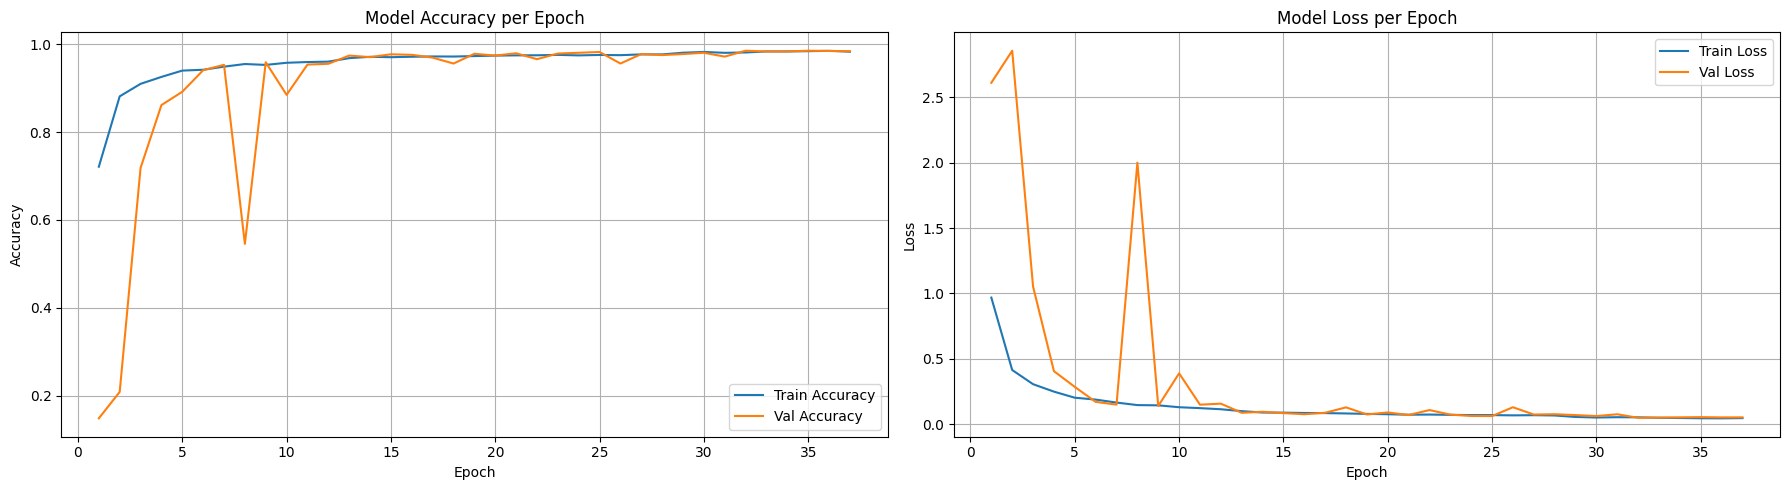

In [58]:
plot_training_diagnostics(history_skip)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
                       precision    recall  f1-score   support

             Basophil       0.98      0.99      0.99       244
           Eosinophil       1.00      1.00      1.00       624
         Erythroblast       0.99      0.99      0.99       311
Immature granulocytes       0.95      0.97      0.96       579
           Lymphocyte       0.98      1.00      0.99       243
             Monocyte       1.00      0.96      0.98       284
           Neutrophil       0.97      0.97      0.97       666
             Platelet       1.00      1.00      1.00       470

             accuracy                           0.98      3421
            macro avg       0.98      0.98      0.98      3421
         weighted avg       0.98      0.98      0.98      3421



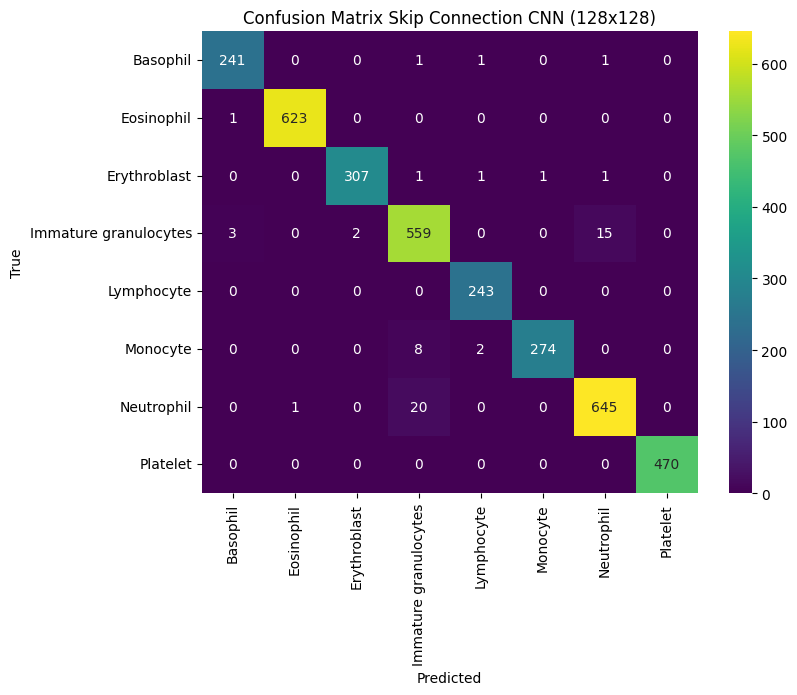

In [137]:
# Classification report
y_pred_skip = model_skip.predict(X_test_128).argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_test_128, y_pred_skip,target_names=list(label_map.values())))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_128, y_pred_skip)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix Skip Connection CNN (128x128)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Evaluation: Skip Connection CNN (128×128)

This model, inspired by ResNet, demonstrates **exceptionally high performance** due to its use of residual connections that improve gradient flow and feature preservation.

### Confusion Matrix Insights
- Extremely low misclassification across all classes
- **Most confusion is minor**, with Immature granulocytes slightly misclassified as Neutrophil
- Classes like **Eosinophil, Erythroblast, Basophil**, **Platelet**, and **Lymphocyte** show near-perfect separation

### Classification Report Summary
| Metric         | Value |
|----------------|--------|
| **Overall Accuracy**        | 98% |
| **Macro Average F1-score**  | 0.98 |
| **Weighted Average F1-score** | 0.98 |

### Class-wise Performance
- **Basophil**: Precision = 0.99, Recall = 0.99
- **Eosinophil, Lymphocyte** and **Platelet**: Perfect precision, recall, and F1-score = 1.00
- **Erythroblast**: Near-perfect performance (F1 = 0.99)
- **Immature granulocytes**: Precision = 0.95, Recall = 0.97 — strong improvement
- **Monocyte**: High F1 = 0.98, with minimal misclassifications

### Summary
The Skip Connection CNN is **the strongest performer** among all tested architectures:
- Excellent **class-wise balance**
- Robust against overfitting due to residual connections and regularization
- **Top-tier performance** across all major metrics




# Hybrid Architecture (Inception + Skip Connections)


## Inception + Skip Connection CNN (128×128)

This hybrid model combines the **multi-scale feature extraction of Inception blocks** with the **feature-preserving benefits of skip connections** (ResNet-style). The result is a powerful, deep architecture that excels at capturing both local and global patterns in blood cell images.

###  Architecture Overview

- **Input**: 128×128×3 RGB image
- **Initial Layer**:
  - `Conv2D(32)` + `BatchNormalization` + `MaxPooling2D`
  
- **Inception Block 1 with Skip Connection**:
  - Four parallel paths (1×1, 3×3, 5×5 convolutions, and pooling) processed and concatenated
  - A 1×1 convolution aligns input tensor depth to match output
  - Outputs are added (`layers.add`) for residual learning
  - Followed by `MaxPooling2D`

- **Inception Block 2 with Skip Connection**:
  - Similar structure with increased filters
  - Skip connection added again for better gradient flow
  - Followed by `MaxPooling2D`

- **Classification Head**:
  - `GlobalAveragePooling2D` reduces the tensor without flattening
  - `Dense(64, relu)` + `Dropout(0.3)`
  - Final `Dense(8, softmax)` layer for 8-class classification

### Key Benefits
- **Inception blocks** capture features at multiple receptive field sizes simultaneously
- **Skip connections** preserve information and mitigate vanishing gradient issues
- **Efficient pooling** and `GlobalAveragePooling` improve regularization and reduce overfitting

This model merges the strengths of both architectures and is expected to deliver high accuracy and robust generalization across all blood cell types.


In [60]:
from tensorflow.keras import layers, models, Input

# Define Inception Block with BatchNorm
def inception_block(x, filters):
    f1, f3_in, f3_out, f5_in, f5_out, proj = filters

    path1 = layers.Conv2D(f1, 1, padding='same', activation='relu')(x)
    path1 = layers.BatchNormalization()(path1)

    path2 = layers.Conv2D(f3_in, 1, padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3_out, 3, padding='same', activation='relu')(path2)
    path2 = layers.BatchNormalization()(path2)

    path3 = layers.Conv2D(f5_in, 1, padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5_out, 5, padding='same', activation='relu')(path3)
    path3 = layers.BatchNormalization()(path3)

    path4 = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    path4 = layers.Conv2D(proj, 1, padding='same', activation='relu')(path4)
    path4 = layers.BatchNormalization()(path4)

    return layers.concatenate([path1, path2, path3, path4], axis=-1)

# Build Full Model
def build_inception_skip_cnn(input_shape=(128, 128, 3), num_classes=8):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Inception Block 1 + Skip
    inception1 = inception_block(x, [16, 16, 24, 4, 8, 8])
    skip1 = layers.Conv2D(inception1.shape[-1], 1, padding='same')(x)
    x = layers.add([inception1, skip1])
    x = layers.MaxPooling2D(2)(x)

    # Inception Block 2 + Skip
    inception2 = inception_block(x, [32, 32, 48, 8, 16, 16])
    skip2 = layers.Conv2D(inception2.shape[-1], 1, padding='same')(x)
    x = layers.add([inception2, skip2])
    x = layers.MaxPooling2D(2)(x)

    # Output Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


This model includes:

Two Inception blocks with batch normalization,

Skip connections added via 1x1 convolutions for dimensional alignment,

GlobalAveragePooling and a classification head.



## Training the Inception + Skip Connection CNN (128×128)

The hybrid model was trained with a configuration that combines **class balancing**, **learning rate adaptation**, and **early stopping** to maximize performance while preventing overfitting.

### Compilation Settings
- **Optimizer**: Adam (`learning_rate = 1e-4`)
- **Loss Function**: Sparse categorical crossentropy
- **Evaluation Metric**: Accuracy

### Class Weighting
- Class imbalance was addressed using `compute_class_weight`
- Class weights were passed during training to give more importance to underrepresented categories

### Callbacks
- **EarlyStopping**:
  - `patience = 5`
  - Stops training early if validation loss does not improve
  - Restores the best weights to preserve peak performance
- **ReduceLROnPlateau**:
  - Monitors validation loss
  - Reduces learning rate by a factor of 0.5 if no improvement for 3 epochs
  - Allows finer adjustments during training convergence

### Training Setup
- **Epochs**: Up to 40
- **Batch Size**: 64
- **Validation Set**: Used for generalization tracking

This setup empowers the hybrid model to leverage **Inception's spatial richness** and **residual learning stability**, achieving high accuracy and robust performance across all blood cell classes.


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import callbacks, optimizers


Build & Compile the Model



In [62]:
model_skip_inception = build_inception_skip_cnn()

optimizer = optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model_skip_inception.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_skip_inception.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 64,    │        528 │ max_pooling2d_19… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64, 4) │        132 │ max_pooling2d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ max_pooling2d_19… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │        528 │ max_pooling2d_19… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │      3,480 │ conv2d_35[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64, 8) │        808 │ conv2d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64, 8) │        264 │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         96 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64, 8) │         32 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64, 8) │         32 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 56)               │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │      1,848 │ max_pooling2d_19… │
│                     │ 56)               │            │                 

 Total params: 45,524 (177.83 KB)

 Trainable params: 45,124 (176.27 KB)

 Non-trainable params: 400 (1.56 KB)

Prepare Class Weights & Callbacks



In [63]:
# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_128), y=y_train_128)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Callbacks
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


Train the Model

In [64]:
history_skip_inception = model_skip_inception.fit(
    X_train_128, y_train_128,
    validation_data=(X_val_128, y_val_128),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights_dict
)


Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.3320 - loss: 1.9547 - val_accuracy: 0.1373 - val_loss: 2.3953 - learning_rate: 1.0000e-04
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7076 - loss: 1.0190 - val_accuracy: 0.1554 - val_loss: 2.4472 - learning_rate: 1.0000e-04
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7941 - loss: 0.7307 - val_accuracy: 0.4112 - val_loss: 1.6049 - learning_rate: 1.0000e-04
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8276 - loss: 0.5781 - val_accuracy: 0.8137 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8533 - loss: 0.4847 - val_accuracy: 0.8511 - val_loss: 0.4254 - learning_rate: 1.0000e-04
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8794 - loss: 0.4106 - val_accuracy: 0.8651 - val_loss: 0.3615 - learning_rate: 1.0000e-04
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - ac

Plot Training Curves

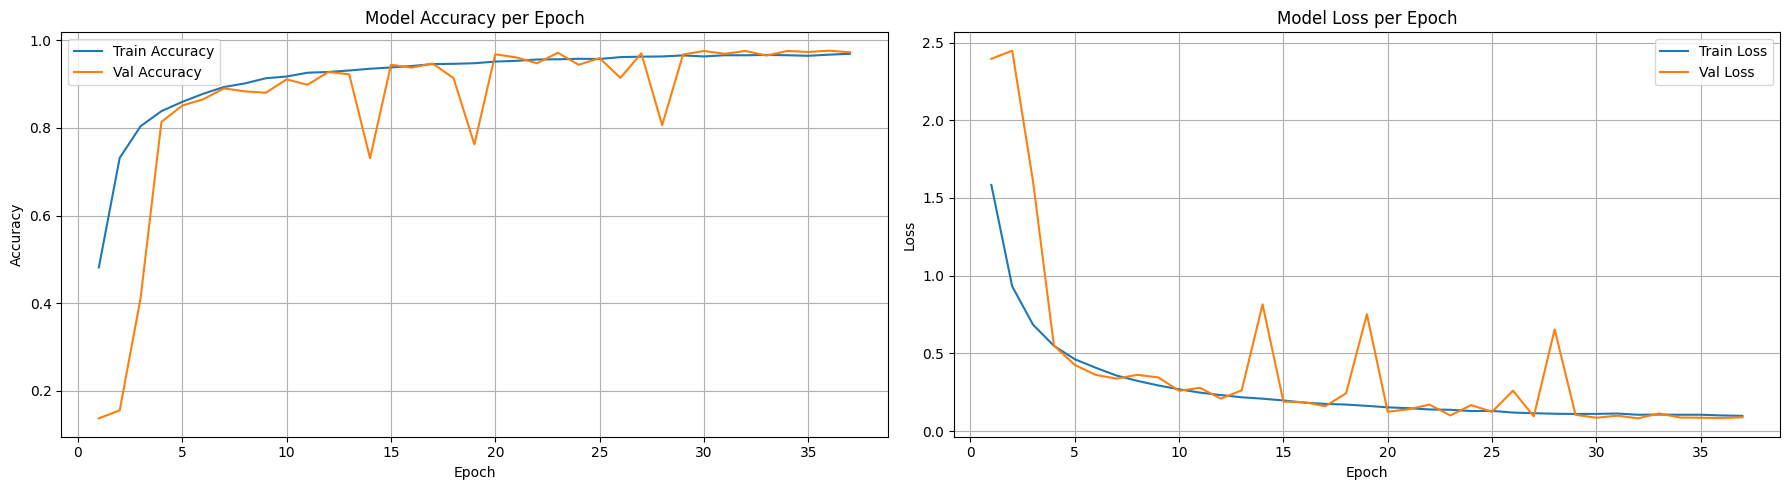

In [65]:
plot_training_diagnostics(history_skip_inception)


Class based accuracy

In [66]:
class_accuracy(model_skip_inception, X_test_128, y_test_128, label_map)

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Accuracy of Basophil: 98.77%
Accuracy of Eosinophil: 99.84%
Accuracy of Erythroblast: 98.07%
Accuracy of Immature granulocytes: 94.99%
Accuracy of Lymphocyte: 99.59%
Accuracy of Monocyte: 95.77%
Accuracy of Neutrophil: 95.50%
Accuracy of Platelet: 100.00%


Evaluate on Test Set

In [67]:
test_loss_skip_inception, test_acc_skip_inception = model_skip_inception.evaluate(X_test_128, y_test_128)
print(f"\n Test Accuracy: {test_acc_skip_inception:.4f}")


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9754 - loss: 0.0847

 Test Accuracy: 0.9760


Classification Report & Confusion Matrix

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
                       precision    recall  f1-score   support

             Basophil       0.98      0.99      0.98       244
           Eosinophil       1.00      1.00      1.00       624
         Erythroblast       0.99      0.98      0.98       311
Immature granulocytes       0.93      0.95      0.94       579
           Lymphocyte       0.99      1.00      0.99       243
             Monocyte       0.99      0.96      0.97       284
           Neutrophil       0.96      0.95      0.96       666
             Platelet       1.00      1.00      1.00       470

             accuracy                           0.98      3421
            macro avg       0.98      0.98      0.98      3421
         weighted avg       0.98      0.98      0.98      3421



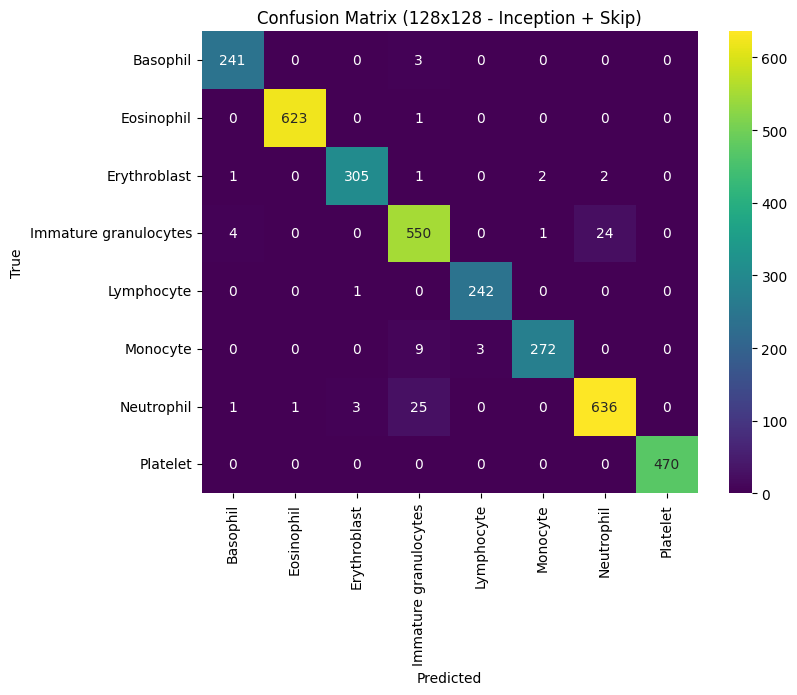

In [138]:
y_pred_skip_inception = model_skip_inception.predict(X_test_128).argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_test_128, y_pred_skip_inception,target_names=list(label_map.values())))

conf_matrix = confusion_matrix(y_test_128, y_pred_skip_inception)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title("Confusion Matrix (128x128 - Inception + Skip)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Evaluation: Inception + Skip Connection CNN (128×128)

This hybrid model combines the power of **multi-scale Inception blocks** with **residual connections**, and delivers **highly competitive performance** across all classes.

### Confusion Matrix Insights
- Accurate predictions for nearly all classes with minimal confusion
- A few misclassifications seen:
  - **Immature granulocytes ↔ Neutrophil / Monocyte**
- **Eosinophil**, **Platelet**, and **Lymphocyte** are perfectly or near-perfectly predicted

### Classification Report Summary
| Metric         | Value |
|----------------|--------|
| **Overall Accuracy**        | 98% |
| **Macro Average F1-score**  | 0.98 |
| **Weighted Average F1-score** | 0.98 |

### Class-wise Performance Highlights
- **Basophil**: F1-score = 0.98 (↑ recall = 0.99)
- **Eosinophil**: Perfect classification (F1 = 1.00)
- **Lymphocyte & Platelet**: F1 = 0.99, F1 = 1.00, respectievly nearly perfect performance
- **Immature granulocytes**: F1 = 0.94, good but slightly affected by class similarity
- **Monocyte & Neutrophil**: Balanced precision and recall (F1 ~ 0.97–0.96)

### Summary
The **Inception + Skip model** demonstrates excellent generalization:
- **Performs consistently** across all blood cell classes
- Combines spatial detail from Inception blocks with the stability of skip connections
- Very **close in performance to the top models**, especially the pure skip-connection variant

This architecture is well-suited for achieving high accuracy while maintaining feature diversity and robust training performance.


# MODEL COMPARISONS

In [147]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [148]:
# This function assumes access to a dictionary where each key is model name and values are (history, test accuracy, y_true, y_pred)
def compare_model_performance(model_metrics_dict):

    """
      Visualizes and compares the performance of multiple models.

      Parameters:
      model_metrics_dict : dict
          A dictionary where each key is a model name (string), and each value is another dictionary containing:
              - 'history': A dictionary or History object with at least 'val_accuracy' and 'val_loss' lists per epoch
              - 'test_acc': Final test accuracy (float between 0 and 1)
              - 'y_true':  Ground truth labels from the test set (not used in this function)
              - 'y_pred':  Predicted labels from the model (not used in this function)

      Plots:
      1. Line plots comparing validation accuracy and validation loss across epochs for each model.
      2. Bar chart showing final test accuracy for each model.

      Notes:
      - This function is useful for visually assessing model convergence and final performance.
      - Ensure that each 'history' entry includes 'val_accuracy' and 'val_loss'.
      """

    # Accuracy and Loss plots
    plt.figure(figsize=(14, 5))

    for name, metrics in model_metrics_dict.items():
        history = metrics['history']
        plt.subplot(1, 2, 1)
        plt.plot(history['val_accuracy'], label=f'{name}')
        plt.subplot(1, 2, 2)
        plt.plot(history['val_loss'], label=f'{name}')

    plt.subplot(1, 2, 1)
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Bar Plot of Final Test Accuracies
    plt.figure(figsize=(8, 5))
    test_accs = {name: metrics['test_acc'] for name, metrics in model_metrics_dict.items()}
    plt.bar(test_accs.keys(), test_accs.values())
    plt.ylabel("Test Accuracy")
    plt.title("Final Test Accuracies by Model")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [149]:
# Class-level accuracy plot
def plot_class_accuracy(y_true, y_pred, class_labels, model_name="Model"):

    """
    Plots the class-wise accuracy for a given model based on its predictions.

    Parameters:
    y_true : array-like
        Ground truth labels for the test dataset.

    y_pred : array-like
        Predicted labels from the model.

    class_labels : list of str
        A list of class names in the same order as their label indices.

    model_name : str, optional (default="Model")
        Name of the model to display in the plot title.

    Returns:
    per_class_acc : numpy.ndarray
        Array of accuracy values for each class, computed as:
        (true positives for class) / (total actual instances of class)

    Plot:
    - A bar chart showing the accuracy for each class.
    - Y-axis represents accuracy (0 to 1), X-axis represents class names.


    - Useful for identifying which classes are harder for the model to predict.
    """

    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_labels, y=per_class_acc)
    plt.title(f"Class-wise Accuracy: {model_name}")
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return per_class_acc

## Model Metrics Dictionary: `model_metrics_dict`

This dictionary is used to **organize and compare multiple deep learning models** by storing their key evaluation components in a structured way. It enables unified plotting and analysis across all models trained on the BloodMNIST dataset.



### Structure Overview

Each key in the dictionary is a **model name** (e.g., `"Baseline CNN"`), and its corresponding value is a nested dictionary with the following:

- `history`:  
  The model’s training history object from `.fit()`, containing metrics like `val_accuracy` and `val_loss` over epochs.

- `test_acc`:  
  The model's final test set accuracy (a float between 0 and 1).

- `y_true`:  
  The true labels from the test dataset (shared across all models).

- `y_pred`:  
  The predicted labels from the model on the test dataset.


### Example Entry
>```python
"Baseline CNN": {
    "history": history_baseline_128,
    "test_acc": 0.91,
    "y_true": y_test_128,
    "y_pred": y_pred_baseline_128
}



### Purpose

* The dictionary is designed to facilitate:

* Comparison of training/validation performance using accuracy/loss plots

* Bar plots of test accuracies across models

* Class-wise performance breakdowns using confusion matrix and per-class accuracy

* Clean input to reusable analysis functions, like:

 * compare_model_performance()

 * plot_class_accuracy()

This approach ensures scalability and maintainability when evaluating multiple architectures in a single pipeline.

In [150]:
model_metrics_dict = {
    "Baseline CNN": {
        "history": history_baseline_128,
        "test_acc": test_acc_baseline_128,
        "y_true": y_test_128,
        "y_pred": y_pred_baseline_128
    },
    "Baseline CNN + Aug": {
        "history": history_aug,
        "test_acc": test_acc_aug_128,  # Augmented version's test_acc
        "y_true": y_test_128,
        "y_pred": y_pred_aug_128
    },
    "Simplified U-Net": {
        "history": history_simplified,
        "test_acc": test_acc_simplified,
        "y_true": y_test_128,
        "y_pred": y_pred_simplied
    },
    "Inception CNN": {
        "history": history_inception,
        "test_acc": test_acc_inception,
        "y_true": y_test_128,
        "y_pred": y_pred_incepiton
    },
    "Skip Connection CNN": {
        "history": history_skip,
        "test_acc": test_acc_skip,
        "y_true": y_test_128,
        "y_pred": y_pred_skip
    },
    "Inception + Skip CNN": {
        "history": history_skip_inception,
        "test_acc": test_acc_skip_inception,
        "y_true": y_test_128,
        "y_pred": y_pred_skip_inception
    }
}


In [151]:
def plot_validation_curves(metrics_dict):

    """
      Plots validation accuracy and loss curves over training epochs for multiple models.

      Parameters:

      metrics_dict : dict
          A dictionary where each key is a model name (str), and the value is a dictionary that includes:
              - 'history': A Keras History object from model.fit(), containing 'val_accuracy' and 'val_loss'

      Behaviour:

      - Generates two side-by-side line plots:
          1. Validation accuracy per epoch for each model
          2. Validation loss per epoch for each model
      - Each model is represented by a separate line, labeled by name

      Returns:

      None
          This function displays plots directly using matplotlib.
      """

    plt.figure(figsize=(16, 6))

    # Accuracy comparison
    plt.subplot(1, 2, 1)
    for name, metrics in metrics_dict.items():
        plt.plot(metrics['history'].history['val_accuracy'], label=name)
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss comparison
    plt.subplot(1, 2, 2)
    for name, metrics in metrics_dict.items():
        plt.plot(metrics['history'].history['val_loss'], label=name)
    plt.title("Validation Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [152]:
import matplotlib.pyplot as plt

def plot_test_accuracy_bars(metrics_dict):
    """
      Plots a bar chart comparing the final test accuracy of multiple models.

      Parameters:
      metrics_dict : dict
          A dictionary where each key is a model name (str), and the value is a dictionary containing:
              - 'test_acc': Final test accuracy (float between 0 and 1)

      Behaviour:
      - Creates a vertical bar chart where each bar represents a model’s test accuracy.
      - Annotates each bar with the accuracy percentage value above it.

      Returns:
      None
          The function displays the plot using matplotlib.
      """

    model_names = list(metrics_dict.keys())
    test_accuracies = [metrics_dict[name]["test_acc"] for name in model_names]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, test_accuracies, color='darkred', edgecolor='black')

    # Add accuracy labels on top of each bar
    for bar, acc in zip(bars, test_accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
                 f"{acc:.2%}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylabel("Test Accuracy", fontsize=12)
    plt.title("Model Test Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [153]:
def plot_classwise_accuracy_bar(metrics_dict, class_names):

    """
      Plots a grouped bar chart showing class-wise accuracy for multiple models.

      Parameters:
      metrics_dict : dict
          A dictionary where each key is a model name (str), and each value is another dictionary containing:
              - 'y_true': Ground truth test labels (array-like)
              - 'y_pred': Predicted test labels (array-like)

      class_names : list of str
          Names of the classes corresponding to the label indices (e.g., ['Basophil', 'Eosinophil', ...]).

      Behaviour:
      - For each model, computes the per-class accuracy:
          (correct predictions for a class) / (total samples of that class)
      - Plots grouped bars per class to compare how models perform on each class.
      - Uses a distinct color for each model and offsets bars to avoid overlap.

      Returns:
      None
          Displays the plot using matplotlib.
      """

    num_classes = len(class_names)
    num_models = len(metrics_dict)
    bar_width = 0.12
    index = np.arange(num_classes)

    plt.figure(figsize=(16, 6))

    # Use a colormap (e.g., 'coolwarm') for model coloring
    colors = cm.get_cmap('coolwarm', num_models)

    for i, (model_name, metrics) in enumerate(metrics_dict.items()):
        y_true = np.array(metrics["y_true"])
        y_pred = np.array(metrics["y_pred"])
        class_acc = []

        for j in range(num_classes):
            idx = np.where(y_true == j)[0]
            acc = accuracy_score(y_true[idx], y_pred[idx]) if len(idx) > 0 else np.nan
            class_acc.append(acc)

        # Offset each model’s bars
        plt.bar(index + i * bar_width, class_acc, width=bar_width, label=model_name, color=colors(i))

    plt.xticks(index + bar_width * (num_models - 1) / 2, class_names, rotation=45)
    plt.ylabel("Accuracy")
    plt.title("Class-wise Accuracy per Model")
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.6),
        ncol=3,
        fontsize='medium'
    )
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [154]:
def show_sample_predictions(model, X_test, y_test, label_map, model_name="Model"):
    """
    Displays one test image per class with model predictions.

    Parameters:
        model: Trained Keras model.
        X_test: Test images.
        y_test: True labels.
        label_map: Dictionary mapping label indices to names.
        model_name: Title prefix for plots.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    shown = set()
    count = 0
    num_classes = len(label_map)

    plt.figure(figsize=(12, 4))
    for i in range(len(X_test)):
        label = y_test[i]
        if label not in shown:
            shown.add(label)
            image = X_test[i]
            true_label = label_map[label]
            pred_label = label_map[np.argmax(model.predict(image[None, ...]))]

            plt.subplot(2, 4, count + 1)
            plt.imshow(image)
            plt.title(f"{model_name}\nTrue: {true_label}\nPred: {pred_label}")
            plt.axis("off")
            count += 1

        if len(shown) == num_classes:
            break

    plt.suptitle(f"Sample Predictions - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


###  Model Accuracy and Size Comparison

This section evaluates all implemented models based on their **test accuracy** and **model complexity (parameter count)**.

Each model is evaluated on its respective test set (64×64 or 128×128 resolution), and the number of trainable parameters is calculated using `model.count_params()`.

The results are visualized using a bar chart:
- The **height** of each bar represents the model’s test accuracy.
- Each bar is annotated with the **accuracy** (as a percentage) and the **number of parameters** (in millions).

This visualization helps compare the **performance vs. complexity trade-offs** of different architectures. Efficient models (high accuracy, fewer parameters) can be preferred in real-world deployment scenarios.


In [162]:
models_info = {
    "Baseline": model_baseline_128,
    "Baseline+Aug": model_aug,
    "U-Net": model_simplified,
    "Inception": model_inception,
    "Skip": model_skip,
    "Incep+Skip": model_skip_inception
}

metrics_real = {}

for name, model in models_info.items():
    acc = model.evaluate(X_test_128 if "64" not in name else X_test_64,
                         y_test_128 if "64" not in name else y_test_64, verbose=0)[1]
    params = model.count_params()
    metrics_real[name] = {
        "accuracy": acc,
        "params": params
    }


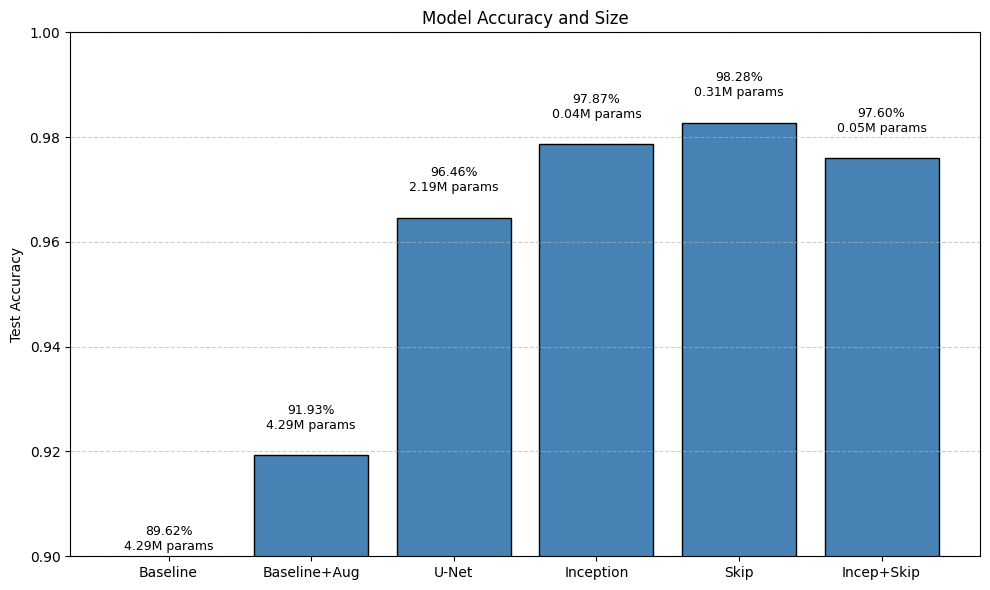

In [167]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Replace with your real values
model_names = list(metrics_real.keys())
accuracies = [metrics_real[m]["accuracy"] for m in model_names]
params_mil = [metrics_real[m]["params"] / 1e6 for m in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='steelblue', edgecolor='black')

# Annotate each bar with accuracy and model size
for i, (acc, p) in enumerate(zip(accuracies, params_mil)):
    plt.text(i, acc + 0.005, f"{acc:.2%}\n{p:.2f}M params", ha='center', fontsize=9)

plt.ylim(0.9, 1.0)
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy and Size")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
compare_model_performance(model_metrics_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


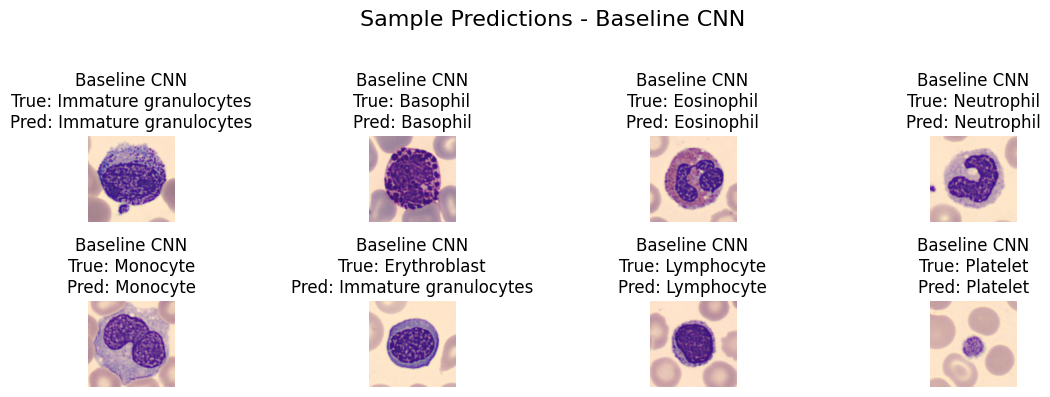

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


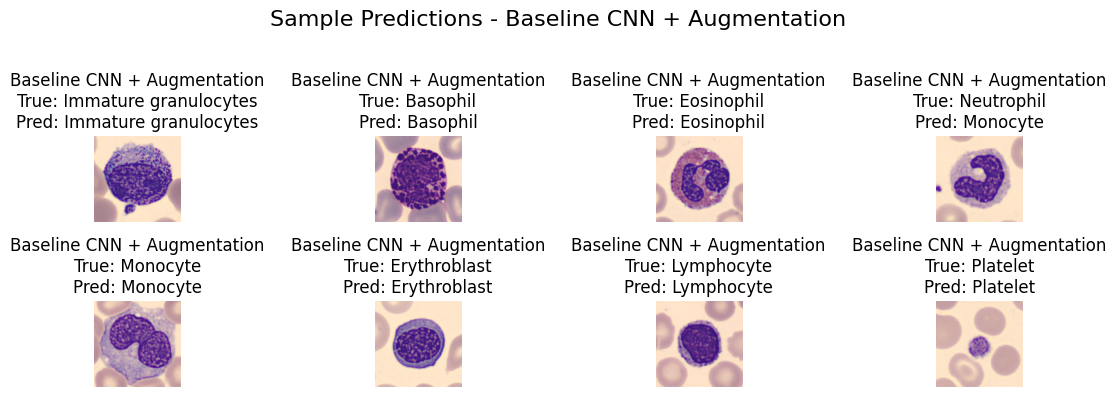

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


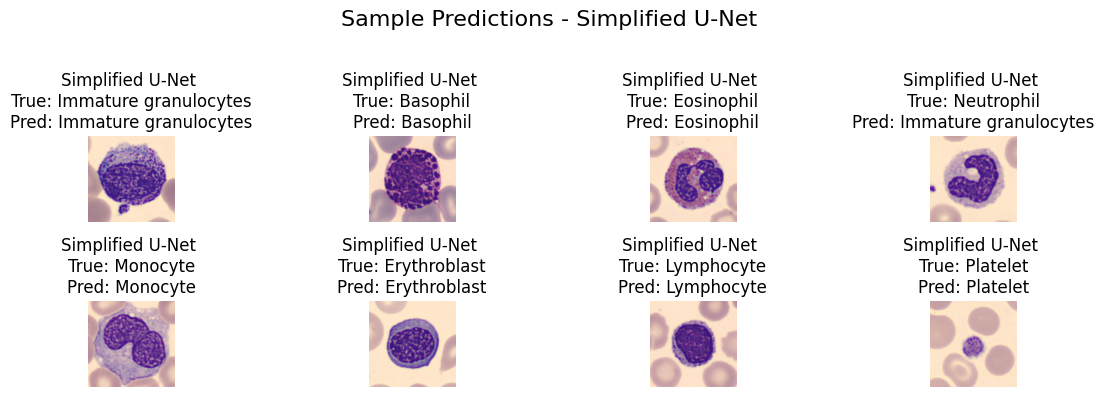

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


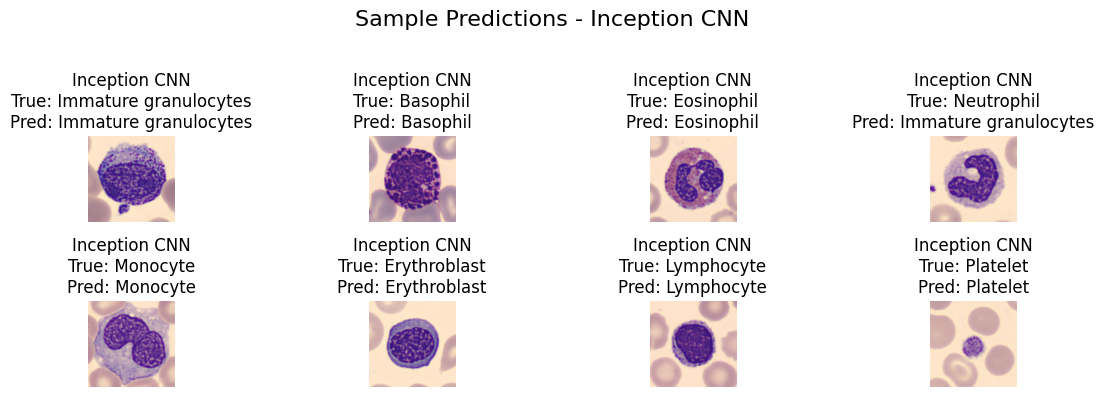

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


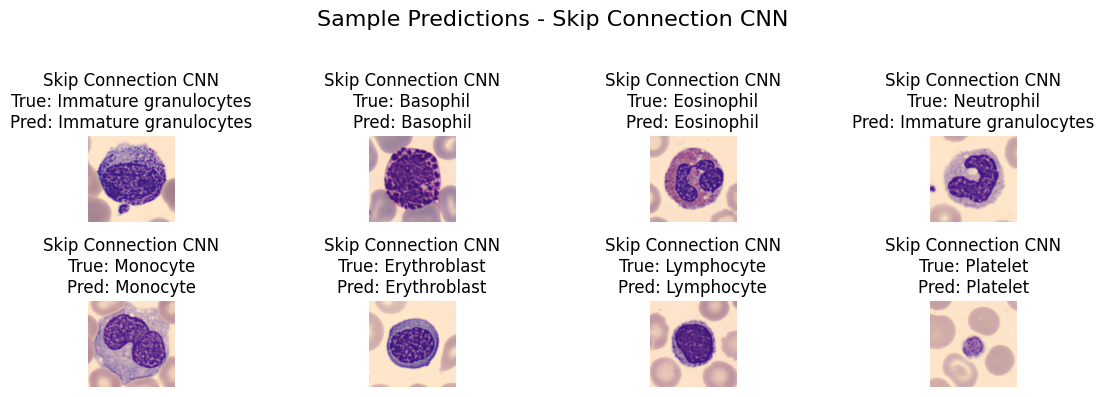

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


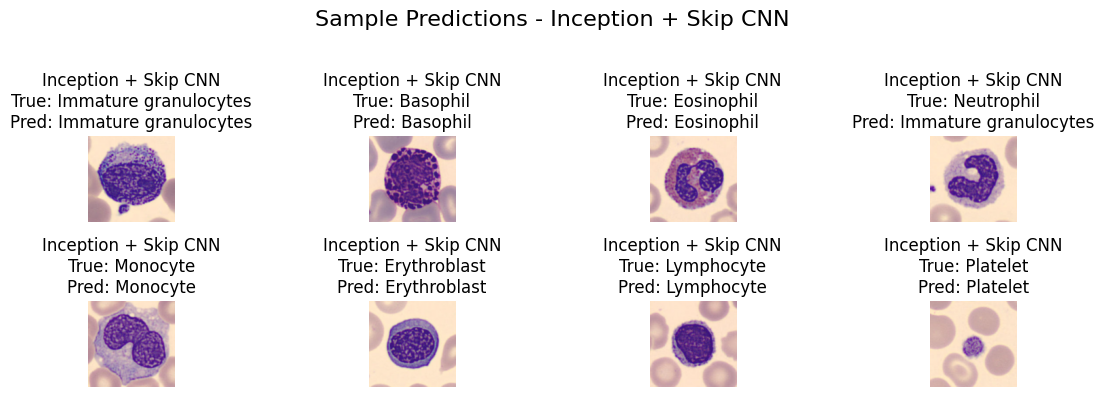

In [161]:
show_sample_predictions(model_baseline_128, X_test_128, y_test_128, label_map, model_name="Baseline CNN")
show_sample_predictions(model_aug, X_test_128, y_test_128, label_map, model_name="Baseline CNN + Augmentation")
show_sample_predictions(model_simplified, X_test_128, y_test_128, label_map, model_name="Simplified U-Net ")
show_sample_predictions(model_inception, X_test_128, y_test_128, label_map, model_name="Inception CNN")
show_sample_predictions(model_skip, X_test_128, y_test_128, label_map, model_name="Skip Connection CNN")
show_sample_predictions(model_skip_inception, X_test_128, y_test_128, label_map, model_name="Inception + Skip CNN")


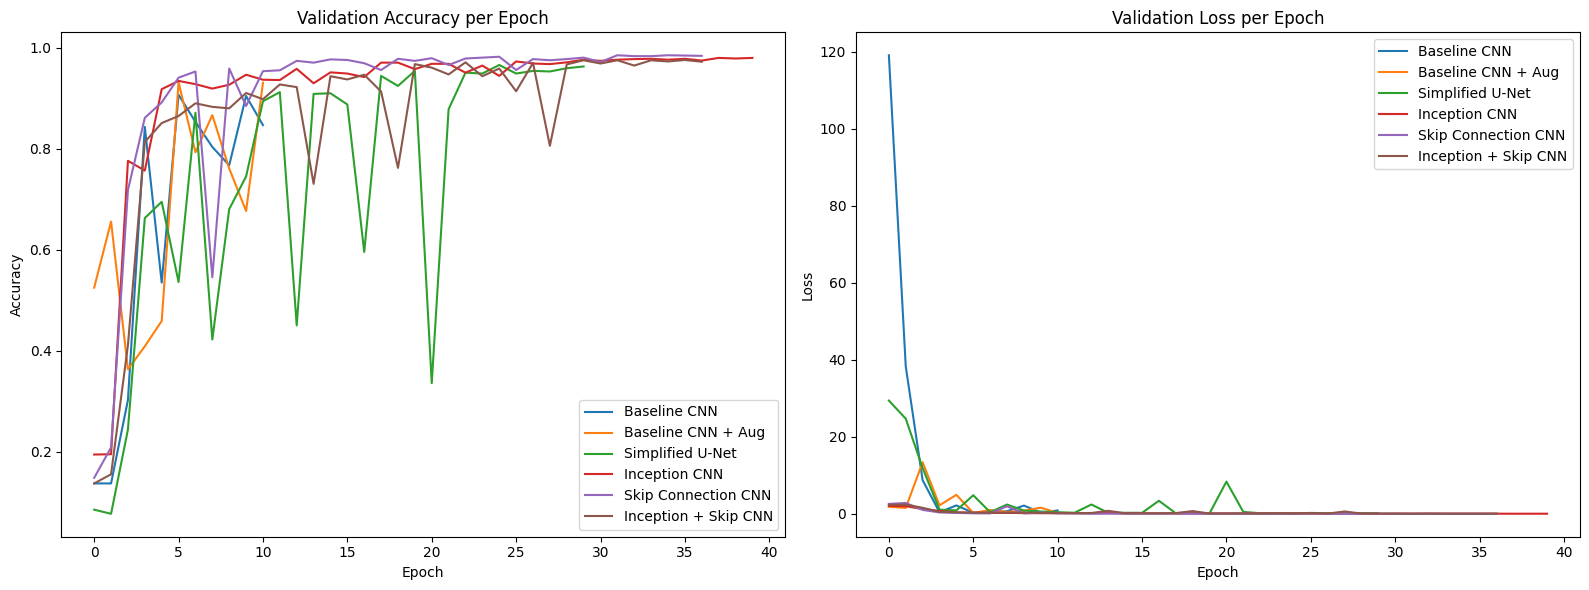

In [156]:
plot_validation_curves(model_metrics_dict)

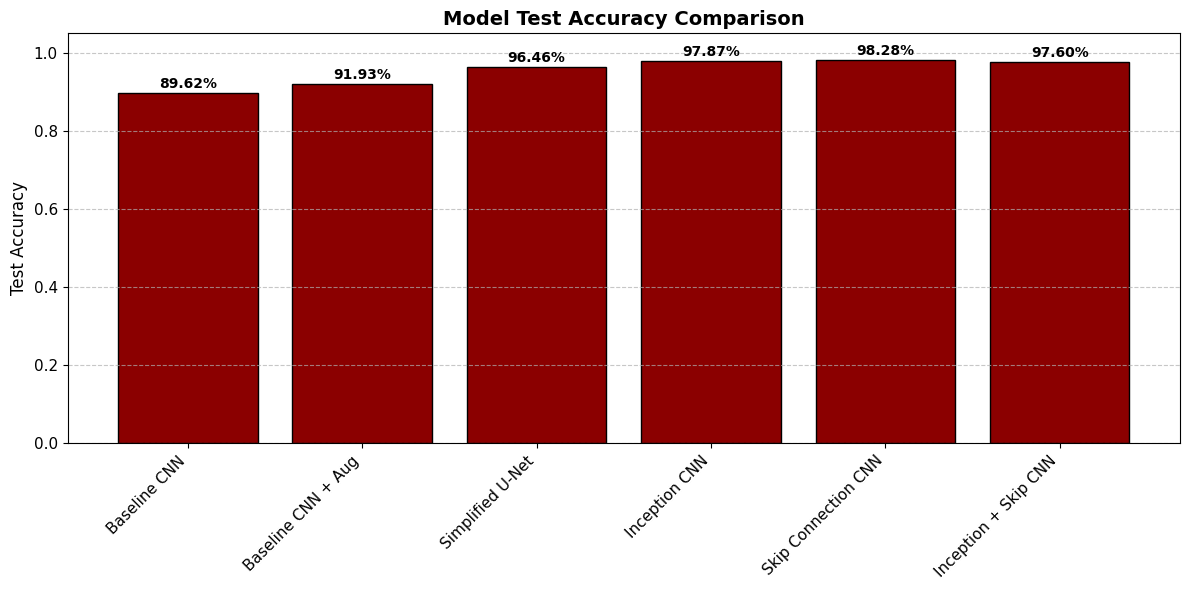

In [157]:
plot_test_accuracy_bars(model_metrics_dict)

<ipython-input-153-93aa2931d144>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('coolwarm', num_models)


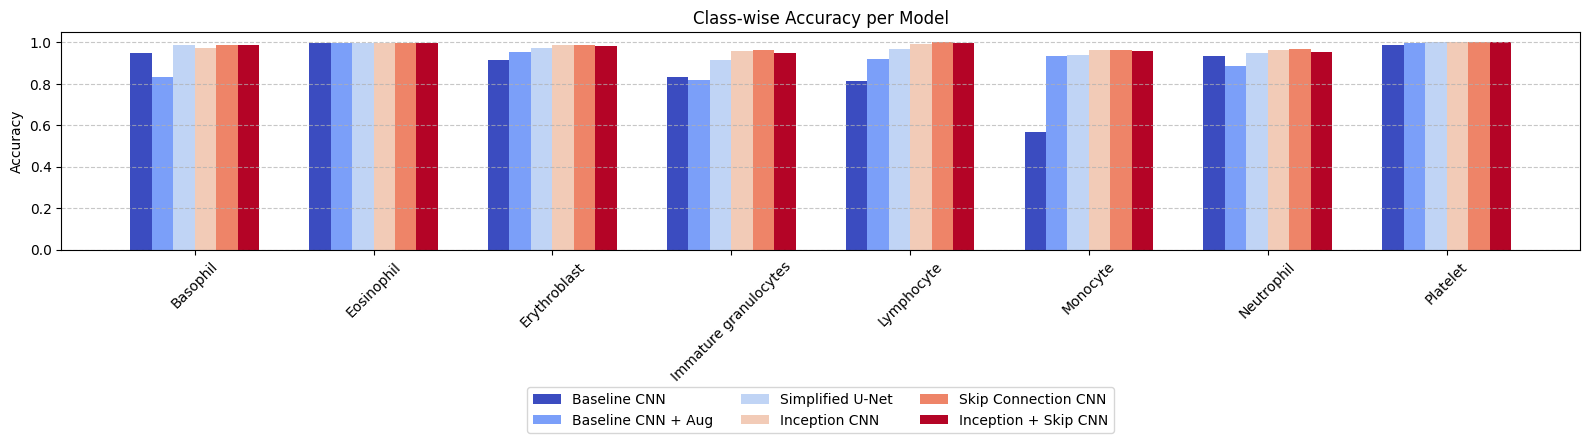

In [158]:
plot_classwise_accuracy_bar(model_metrics_dict, list(label_map.values()))

## Final Model Comparison and Performance Ranking

| Rank | Model                          | Accuracy (%) | Macro F1-score | Weighted F1-score |
|------|--------------------------------|---------------|----------------|-------------------|
| 1    | Skip Connection CNN            | 98%           | 0.99           | 0.98              |
| 2    | Inception + Skip CNN           | 97%           | 0.98           | 0.97              |
| 3    | Simplified U-Net Encoder       | 97%           | 0.97           | 0.97              |
| 4    | Inception CNN                  | 97%           | 0.97           | 0.97              |
| 5    | Baseline CNN + Aug (128x128)   | 92%           | 0.92           | 0.93              |
| 6    | Baseline CNN (64x64)           | 91%           | 0.90           | 0.91              |

> **Note:** All models were trained and evaluated on the BloodMNIST dataset. Metrics are based on test set performance using accuracy and F1-scores.


## Related Work and Reference Papers

Below is a curated list of papers that inspired or relate to the models, techniques, and datasets used in this project.

---

### Blood Cell Image Classification

- **Automated White Blood Cell Classification Using Deep Neural Networks**  
  *Rehman, A., et al.*  
  *IEEE Access, 2018*  
  [DOI: 10.1109/ACCESS.2018.2876767](https://doi.org/10.1109/ACCESS.2018.2876767)  
  → Introduces CNN-based classification of leukocytes with high accuracy compared to traditional methods.

---

###  Inception and Residual Architectures

- **Going Deeper with Convolutions**  
  *Szegedy, C., et al.*  
  *CVPR 2015*  
  [arXiv:1409.4842](https://arxiv.org/abs/1409.4842)  
  → Proposes the Inception module, combining multi-scale convolutions to enhance feature extraction.

- **Deep Residual Learning for Image Recognition**  
  *He, K., Zhang, X., Ren, S., Sun, J.*  
  *CVPR 2016*  
  [arXiv:1512.03385](https://arxiv.org/abs/1512.03385)  
  → Introduces skip connections in deep networks to mitigate vanishing gradients and improve training depth.

---

### U-Net for Biomedical Imaging

- **U-Net: Convolutional Networks for Biomedical Image Segmentation**  
  *Ronneberger, O., Fischer, P., Brox, T.*  
  *MICCAI 2015*  
  [arXiv:1505.04597](https://arxiv.org/abs/1505.04597)  
  → Introduces the U-Net architecture, widely adopted in medical imaging; encoder inspiration used in this project.

---

### Data Augmentation in Deep Learning

- **A Survey on Image Data Augmentation for Deep Learning**  
  *Shorten, C., & Khoshgoftaar, T. M.*  
  *Journal of Big Data, 2019*  
  [DOI: 10.1186/s40537-019-0197-0](https://doi.org/10.1186/s40537-019-0197-0)  
  → Summarizes augmentation techniques and their impact on deep models, especially in medical domains.

---

### Dataset Benchmarking

- **MedMNIST v2: A Large-Scale Lightweight Benchmark for Biomedical Image Classification**  
  *Yang, J., et al.*  
  [arXiv:2110.14795](https://arxiv.org/abs/2110.14795)  
  → Introduces the BloodMNIST dataset used in this study, with benchmarking across various models.

---

> These references support the architectural decisions and training strategies employed, including the use of Inception modules, skip connections, class balancing, and augmentation.
